In [1]:
import pandas as pd
import unicodedata
from pathlib import Path

# ============================
# 0) AJUSTE OS CAMINHOS AQUI
# ============================
ARQ_ALP = r"C:\Users\pedro\OneDrive\Documentos\Análise dados\alpargatas\Projetos_de_Atuac807a771o_-_IA_-_2020_a_2025 (1).xlsx"
ARQ_DTB = r"C:\Users\pedro\OneDrive\Documentos\Análise dados\alpargatas\RELATORIO_DTB_BRASIL_2024_MUNICIPIOS.ods"
SAIDA_DIR = r"C:\Users\pedro\OneDrive\Documentos\Análise dados\alpargatas"  # pasta onde quer salvar os CSVs


In [2]:

# =========================================================
# 1) Utilitários curtos
# =========================================================
def nrm(txt: object) -> str:
    """Normaliza: remove acentos, vira CAIXA-ALTA e tira espaços. NaN -> ''."""
    if pd.isna(txt):
        return ""
    s = str(txt)
    s = unicodedata.normalize("NFKD", s).encode("ASCII", "ignore").decode("ASCII")
    return s.upper().strip()

def chave_municipio(nome: str) -> str:
    """
    Chave 'suave' para casamentos:
    - caixa alta
    - remove pontuações leves
    - corta sufixos que atrapalham match (ex.: ' - ...', ' MIXING CENTER').
    """
    n = nrm(nome).replace("–", "-").replace("—", "-")
    if " - " in n:           # corta qualquer coisa depois de ' - '
        n = n.split(" - ")[0]
    for suf in (" MIXING CENTER", " DISTRITO", " DISTRITO INDUSTRIAL"):
        if n.endswith(suf):
            n = n[: -len(suf)].strip()
    return n

def acha_linha_header_cidades_uf(df_no_header: pd.DataFrame) -> int | None:
    """Retorna o índice da primeira linha que contenha CIDADES e UF (após normalização)."""
    for i, row in df_no_header.iterrows():
        vals = [nrm(x) for x in row.tolist()]
        if "CIDADES" in vals and "UF" in vals:
            return i
    return None

# =========================================================
# 2) Ler & limpar DTB/IBGE
# =========================================================
def carrega_dtb(path: str) -> pd.DataFrame:
    """Lê DTB/IBGE e devolve DataFrame com colunas-chave já limpas e prontas."""
    # Mapa Nome_UF -> Sigla
    UF_SIGLAS = {
        "ACRE":"AC","ALAGOAS":"AL","AMAPÁ":"AP","AMAZONAS":"AM","BAHIA":"BA",
        "CEARÁ":"CE","DISTRITO FEDERAL":"DF","ESPÍRITO SANTO":"ES","GOIÁS":"GO",
        "MARANHÃO":"MA","MATO GROSSO":"MT","MATO GROSSO DO SUL":"MS","MINAS GERAIS":"MG",
        "PARÁ":"PA","PARAÍBA":"PB","PARANÁ":"PR","PERNAMBUCO":"PE","PIAUÍ":"PI",
        "RIO DE JANEIRO":"RJ","RIO GRANDE DO NORTE":"RN","RIO GRANDE DO SUL":"RS",
        "RONDÔNIA":"RO","RORAIMA":"RR","SANTA CATARINA":"SC","SÃO PAULO":"SP",
        "SERGIPE":"SE","TOCANTINS":"TO"
    }

    # A DTB costuma trazer linhas de título/cabeçalhos antes dos dados
    # → usamos skiprows=6 (ajuste se necessário).
    raw = pd.read_excel(path, engine="odf", skiprows=6)

    # Seleciona/renomeia o que interessa e padroniza
    dtb = (raw.rename(columns={
                "UF": "UF_COD_NUM",
                "Nome_UF": "UF_NOME",
                "Código Município Completo": "MUNICIPIO_CODIGO",
                "Nome_Município": "MUNICIPIO_NOME"
            })[["UF_COD_NUM","UF_NOME","MUNICIPIO_CODIGO","MUNICIPIO_NOME"]]
           .dropna(subset=["UF_NOME","MUNICIPIO_CODIGO","MUNICIPIO_NOME"]))

    dtb["UF_SIGLA"]           = dtb["UF_NOME"].astype(str).str.upper().map(UF_SIGLAS)
    dtb["MUNICIPIO_CODIGO"]   = dtb["MUNICIPIO_CODIGO"].astype(str).str.zfill(7)
    dtb["MUNICIPIO_NOME"]     = dtb["MUNICIPIO_NOME"].astype(str).str.upper().str.strip()
    dtb["MUNICIPIO_CHAVE"]    = dtb["MUNICIPIO_NOME"].apply(chave_municipio)

    return dtb[["UF_SIGLA","MUNICIPIO_CODIGO","MUNICIPIO_NOME","MUNICIPIO_CHAVE"]]

# =========================================================
# 3) Ler abas do arquivo Alpargatas (2020–2025) e extrair cidade/UF
# =========================================================
def carrega_alpargatas(path: str) -> pd.DataFrame:
    """Lê todas as abas (2020–2025), detecta header e extrai CIDADES/UF em um único DataFrame."""
    xls = pd.ExcelFile(path)
    abas = [a for a in xls.sheet_names if any(str(ano) in a for ano in range(2020, 2026))]
    if not abas:
        raise RuntimeError("Nenhuma aba 2020–2025 encontrada no arquivo Alpargatas.")

    frames = []
    for aba in abas:
        # Lê as primeiras linhas sem header só para acharmos onde começa CIDADES/UF
        nohdr = pd.read_excel(path, sheet_name=aba, header=None, nrows=400)
        hdr   = acha_linha_header_cidades_uf(nohdr)
        if hdr is None:
            print(f"[AVISO] Não achei cabeçalho CIDADES/UF na aba '{aba}'. Pulando…")
            continue

        df = pd.read_excel(path, sheet_name=aba, header=hdr)

        # Descobre as colunas "Cidades" e "UF" em qualquer grafia
        cmap = {c: nrm(c) for c in df.columns}
        c_cid = next((orig for orig, norm in cmap.items() if norm == "CIDADES"), None)
        c_uf  = next((orig for orig, norm in cmap.items() if norm == "UF"), None)
        if not c_cid or not c_uf:
            print(f"[AVISO] Colunas 'CIDADES'/'UF' não encontradas após header na aba '{aba}'.")
            continue

        tmp = (df[[c_cid, c_uf]].copy()
                 .rename(columns={c_cid:"MUNICIPIO_NOME_ALP", c_uf:"UF_SIGLA"}))
        tmp["MUNICIPIO_NOME_ALP"] = tmp["MUNICIPIO_NOME_ALP"].astype(str).str.upper().str.strip()
        tmp["UF_SIGLA"]           = tmp["UF_SIGLA"].astype(str).str.strip()
        tmp = tmp.dropna(subset=["MUNICIPIO_NOME_ALP","UF_SIGLA"])
        tmp = tmp[tmp["MUNICIPIO_NOME_ALP"].str.len() > 0]

        tmp["MUNICIPIO_CHAVE"] = tmp["MUNICIPIO_NOME_ALP"].apply(chave_municipio)
        tmp["FONTE_ABA"]       = aba
        frames.append(tmp)

    if not frames:
        raise RuntimeError("Nenhuma aba válida foi processada (CIDADES/UF não encontrado).")

    # remove duplicados entre abas (mesma cidade/UF pode aparecer em mais de uma aba)
    return pd.concat(frames, ignore_index=True).drop_duplicates(["MUNICIPIO_CHAVE","UF_SIGLA"])

# =========================================================
# 4) Cruzamento e saída
# =========================================================
def cruzar_e_salvar(dtb: pd.DataFrame, alpa: pd.DataFrame, saida_dir: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Casa Alpargatas × IBGE usando (MUNICIPIO_CHAVE, UF_SIGLA).
    Salva:
      - municipios_alpargatas_codificados.csv
      - municipios_nao_encontrados_para_tratar.csv
    Retorna (codificados, nao_encontrados)
    """
    codificados = alpa.merge(
        dtb, on=["MUNICIPIO_CHAVE","UF_SIGLA"], how="left", suffixes=("_ALP","_IBGE")
    )

    nao_encontrados = (codificados[codificados["MUNICIPIO_CODIGO"].isna()]
                       .drop_duplicates(subset=["MUNICIPIO_NOME_ALP","UF_SIGLA"])
                       .sort_values(["UF_SIGLA","MUNICIPIO_NOME_ALP"]))

    Path(saida_dir).mkdir(parents=True, exist_ok=True)
    codificados.to_csv(Path(saida_dir, "municipios_alpargatas_codificados.csv"), index=False, encoding="utf-8")
    nao_encontrados.to_csv(Path(saida_dir, "municipios_nao_encontrados_para_tratar.csv"), index=False, encoding="utf-8")

    print(f"\nConcluído:")
    print(f" - Codificados: {len(codificados):>6} (arquivo salvo)")
    print(f" - Para revisar: {len(nao_encontrados):>6} (arquivo salvo)")

    return codificados, nao_encontrados

# =========================================================
# 5) Execução
# =========================================================
if __name__ == "__main__":
    print("Lendo DTB/IBGE…")
    dtb  = carrega_dtb(ARQ_DTB)

    print("Lendo abas do arquivo Alpargatas…")
    alpa = carrega_alpargatas(ARQ_ALP)

    print("Cruzando e salvando…")
    codificados, nao_encontrados = cruzar_e_salvar(dtb, alpa, SAIDA_DIR)

    # Visão rápida (opcional)
    print("\nAmostra codificados:")
    print(codificados.head(10).to_string(index=False))


Lendo DTB/IBGE…
Lendo abas do arquivo Alpargatas…


c:\Users\pedro\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Failed to load a conditional formatting rule. It will be discarded. Cause: expected <class 'openpyxl.worksheet.cell_range.MultiCellRange'>
  for idx, row in parser.parse():
c:\Users\pedro\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Failed to load a conditional formatting rule. It will be discarded. Cause: expected <class 'openpyxl.worksheet.cell_range.MultiCellRange'>
  for idx, row in parser.parse():
c:\Users\pedro\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Failed to load a conditional formatting rule. It will be discarded. Cause: expected <class 'openpyxl.worksheet.cell_range.MultiCellRange'>
  for idx, row in parser.parse():
c:\Users\pedro\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Failed to load a conditional formatting rule. It will be discarded. Cause: expected <class 'openpyxl.workshee

[AVISO] Não achei cabeçalho CIDADES/UF na aba 'Doações Realizada 2024 Linaldo'. Pulando…


c:\Users\pedro\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Failed to load a conditional formatting rule. It will be discarded. Cause: expected <class 'openpyxl.worksheet.cell_range.MultiCellRange'>
  for idx, row in parser.parse():
c:\Users\pedro\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Failed to load a conditional formatting rule. It will be discarded. Cause: expected <class 'openpyxl.worksheet.cell_range.MultiCellRange'>
  for idx, row in parser.parse():


[AVISO] Não achei cabeçalho CIDADES/UF na aba '2022'. Pulando…
[AVISO] Não achei cabeçalho CIDADES/UF na aba 'Resumo NºIA 2023 - Sustentabili'. Pulando…
[AVISO] Não achei cabeçalho CIDADES/UF na aba 'Doações IA 2023'. Pulando…
[AVISO] Não achei cabeçalho CIDADES/UF na aba '2021'. Pulando…
[AVISO] Não achei cabeçalho CIDADES/UF na aba '2020'. Pulando…
Cruzando e salvando…

Concluído:
 - Codificados:     85 (arquivo salvo)
 - Para revisar:     34 (arquivo salvo)

Amostra codificados:
           MUNICIPIO_NOME_ALP UF_SIGLA MUNICIPIO_CHAVE FONTE_ABA MUNICIPIO_CODIGO  MUNICIPIO_NOME
                  ALAGOA NOVA       PB     ALAGOA NOVA      2025          2500403     ALAGOA NOVA
              BAÍA DA TRAIÇÃO       PB BAIA DA TRAICAO      2025          2501401 BAÍA DA TRAIÇÃO
                   BANANEIRAS       PB      BANANEIRAS      2025          2501500      BANANEIRAS
                   CABACEIRAS       PB      CABACEIRAS      2025          2503100      CABACEIRAS
               CAMPINA 

In [3]:
# Adicionar manualmente o código de CAMPINA GRANDE (PB) se estiver NaN
mask = (codificados["MUNICIPIO_NOME_ALP"].str.contains("CAMPINA GRANDE", case=False, na=False)) & \
       (codificados["UF_SIGLA"] == "PB") & \
       (codificados["MUNICIPIO_CODIGO"].isna())

codificados.loc[mask, "MUNICIPIO_CODIGO"] = "2504009"



In [4]:
codificados.head(18)

,MUNICIPIO_NOME_ALP,UF_SIGLA,MUNICIPIO_CHAVE,FONTE_ABA,MUNICIPIO_CODIGO,MUNICIPIO_NOME
0,ALAGOA NOVA,PB,ALAGOA NOVA,2025,2500403,ALAGOA NOVA
1,BAÍA DA TRAIÇÃO,PB,BAIA DA TRAICAO,2025,2501401,BAÍA DA TRAIÇÃO
2,BANANEIRAS,PB,BANANEIRAS,2025,2501500,BANANEIRAS
3,CABACEIRAS,PB,CABACEIRAS,2025,2503100,CABACEIRAS
4,CAMPINA GRANDE,PB,CAMPINA GRANDE,2025,2504009,CAMPINA GRANDE
5,CAMPINA GRANDE- MIXING CENTER,PB,CAMPINA GRANDE-,2025,2504009,NaN
6,CARPINA,PE,CARPINA,2025,2604007,CARPINA
7,CATURITÉ,PB,CATURITE,2025,2504355,CATURITÉ
8,GUARABIRA,PB,GUARABIRA,2025,2506301,GUARABIRA
9,INGÁ,PB,INGA,2025,2506806,INGÁ


In [5]:
remover = ["MUNICIPIO_NOME_IBGE"]
codificados = codificados.drop(columns=remover, errors="ignore")

In [6]:
ods_iniciais = r"C:\Users\pedro\OneDrive\Documentos\Análise dados\alpargatas\divulgacao_anos_iniciais_municipios_2023.xlsx"
ods_finais = r"C:\Users\pedro\OneDrive\Documentos\Análise dados\alpargatas\divulgacao_anos_finais_municipios_2023.xlsx"
ods_em = r"C:\Users\pedro\OneDrive\Documentos\Análise dados\alpargatas\divulgacao_ensino_medio_municipios_2023.xlsx"

df_iniciais = pd.read_excel(ods_iniciais, header= 9)
df_finais = pd.read_excel(ods_finais, header = 9)
df_em = pd.read_excel(ods_em, header = 9)


In [7]:
df_iniciais.head(10)

,SG_UF,CO_MUNICIPIO,NO_MUNICIPIO,REDE,VL_APROVACAO_2005_SI_4,VL_APROVACAO_2005_SI,VL_APROVACAO_2005_1,VL_APROVACAO_2005_2,VL_APROVACAO_2005_3,VL_APROVACAO_2005_4,...,VL_OBSERVADO_2021,VL_OBSERVADO_2023,VL_PROJECAO_2007,VL_PROJECAO_2009,VL_PROJECAO_2011,VL_PROJECAO_2013,VL_PROJECAO_2015,VL_PROJECAO_2017,VL_PROJECAO_2019,VL_PROJECAO_2021
0,RO,1100015.0,Alta Floresta D'Oeste,Estadual,77.2,-,70.4,78.2,73.7,82.5,...,4.6,5.9,3.6,3.9,4.3,4.6,4.9,5.2,5.5,5.7
1,RO,1100015.0,Alta Floresta D'Oeste,Municipal,-,-,-,-,-,-,...,4.8,5.1,-,-,-,-,-,5.3,5.5,5.8
2,RO,1100015.0,Alta Floresta D'Oeste,Pública,80.9,-,73,81.5,81.1,87.9,...,4.8,5.3,3.8,4.1,4.5,4.8,5.1,5.4,5.7,5.9
3,RO,1100023.0,Ariquemes,Estadual,87.1,-,83.3,88.6,88.5,87.5,...,5.8,6.1,4.1,4.4,4.8,5.1,5.4,5.6,5.9,6.2
4,RO,1100023.0,Ariquemes,Municipal,85.7,93,79,87.3,86.1,87.4,...,4.5,5.3,3.6,3.9,4.3,4.6,4.9,5.2,5.5,5.8
5,RO,1100023.0,Ariquemes,Pública,86,93,79.7,87.6,86.8,87.4,...,4.7,5.4,3.8,4.1,4.5,4.8,5.1,5.4,5.7,5.9
6,RO,1100031.0,Cabixi,Estadual,92.6,-,75,93,98,94.6,...,-,-,4.2,4.5,4.9,5.2,5.5,5.7,6,6.3
7,RO,1100031.0,Cabixi,Municipal,83.5,-,70.8,89.3,87.2,90.4,...,5.1,5.8,3.5,3.8,4.2,4.5,4.8,5.1,5.4,5.7
8,RO,1100031.0,Cabixi,Pública,86.2,-,71.5,90.3,89.8,92.6,...,5.1,5.8,3.7,4.1,4.5,4.8,5.1,5.3,5.6,5.9
9,RO,1100049.0,Cacoal,Estadual,84,-,76.8,79.1,88.8,89.3,...,5.7,6,3.8,4.2,4.6,4.9,5.1,5.4,5.7,6


In [8]:
import numpy as np

# ============================================================
# 1) Função utilitária: calcula a MÉDIA do indicador (VL_INDICADOR_REND_2023)
#    por município em um DataFrame qualquer, e devolve
#    um DataFrame com duas colunas: CO_MUNICIPIO e <rótulo_saida>.
def media_por_municipio(df: pd.DataFrame, rotulo_saida: str) -> pd.DataFrame:
    # Faz uma cópia para não alterar o df original fora da função
    df = df.copy()

    # 1.1) Padroniza o código do município (IBGE) como string com 7 dígitos.
    #      - extrai apenas números (7 dígitos) caso venham misturados
    #      - preenche com zeros à esquerda se precisar (zfill)
    df["CO_MUNICIPIO"] = (
        df["CO_MUNICIPIO"]
        .astype(str)
        .str.extract(r"(\d{7})", expand=False)  # se tiver mais coisa na célula, pega só os 7 dígitos
        .str.zfill(7)
    )

    # 1.2) Converte a coluna do indicador para numérico.
    #      - errors='coerce' transforma valores inválidos ('-', strings etc.) em NaN
    ind = pd.to_numeric(df["VL_INDICADOR_REND_2023"], errors="coerce")

    # 1.3) Calcula a MÉDIA do indicador por município (ignora NaN automaticamente).
    #      - faz um DataFrame com as duas colunas: CO_MUNICIPIO e rotulo_saida
    #      - agrupa por CO_MUNICIPIO e calcula mean()
    out = (
        pd.DataFrame({"CO_MUNICIPIO": df["CO_MUNICIPIO"], rotulo_saida: ind})
        .groupby("CO_MUNICIPIO", as_index=False)[rotulo_saida]
        .mean()
    )

    # Devolve um DF com CO_MUNICIPIO e a média do indicador
    return out


# 2) Calcula as três TABELAS (uma para cada etapa):
#    - anos iniciais
#    - anos finais
#    - ensino médio
#    Cada uma com a coluna "CO_MUNICIPIO" + "TAXA_APROVACAO_<ETAPA>_P"

ini = media_por_municipio(df_iniciais, "TAXA_APROVACAO_INICIAIS_P")
fin = media_por_municipio(df_finais,   "TAXA_APROVACAO_FINAIS_P")
med = media_por_municipio(df_em,       "TAXA_APROVACAO_MEDIO_P")

# ============================================================
# Cria também colunas em percentual
# ============================================================
ini["TAXA_APROVACAO_INICIAIS_%"] = ini["TAXA_APROVACAO_INICIAIS_P"] * 100
fin["TAXA_APROVACAO_FINAIS_%"]   = fin["TAXA_APROVACAO_FINAIS_P"]   * 100
med["TAXA_APROVACAO_MEDIO_%"]    = med["TAXA_APROVACAO_MEDIO_P"]    * 100

# ============================================================
# 3) Faz o MERGE com a sua base "codificados" (municípios alvo):
#    - garante MUNICIPIO_CODIGO com 7 dígitos
#    - junta (left) as médias calculadas de cada etapa por código IBGE
#    - remove colunas duplicadas de CO_MUNICIPIO criadas pelos merges
# ============================================================
res = codificados.copy()

# 3.1) Padroniza o código do município na base principal
res["MUNICIPIO_CODIGO"] = (
    res["MUNICIPIO_CODIGO"]
    .astype(str)
    .str.extract(r"(\d{7})", expand=False)
    .str.zfill(7)
)

# 3.2) MERGE com as três tabelas calculadas (um left-join para manter todos os municípios da base)
#      Observação: usamos suffixes diferentes nos merges 2 e 3 para evitar conflitos de nomes
res = (
    res
    .merge(ini, left_on="MUNICIPIO_CODIGO", right_on="CO_MUNICIPIO", how="left")                                  # anos iniciais
    .merge(fin, left_on="MUNICIPIO_CODIGO", right_on="CO_MUNICIPIO", how="left", suffixes=("", "_fin"))           # anos finais
    .merge(med, left_on="MUNICIPIO_CODIGO", right_on="CO_MUNICIPIO", how="left", suffixes=("", "_med"))           # ensino médio
)

# 3.3) Remove colunas CO_MUNICIPIO repetidas (geradas pelos merges)
for c in ["CO_MUNICIPIO", "CO_MUNICIPIO_fin", "CO_MUNICIPIO_med"]:
    if c in res.columns:
        res.drop(columns=c, inplace=True)

# ============================================================
# 4) Arredonda para Visualização:
#    - *_P (proporção) com 4 casas
#    - *_% (percentual) com 2 casas
# ============================================================
for c in ["TAXA_APROVACAO_INICIAIS_P", "TAXA_APROVACAO_FINAIS_P", "TAXA_APROVACAO_MEDIO_P"]:
    if c in res.columns:
        res[c] = res[c].round(4)

for c in ["TAXA_APROVACAO_INICIAIS_%", "TAXA_APROVACAO_FINAIS_%", "TAXA_APROVACAO_MEDIO_%"]:
    if c in res.columns:
        res[c] = res[c].round(2)

# ============================================================
# 5) Prévia das colunas principais para conferir o resultado
# ============================================================
cols_show = [
    "MUNICIPIO_CODIGO", "UF_SIGLA", "MUNICIPIO_NOME_ALP",
    "TAXA_APROVACAO_INICIAIS_P", "TAXA_APROVACAO_FINAIS_P", "TAXA_APROVACAO_MEDIO_P",
    "TAXA_APROVACAO_INICIAIS_%", "TAXA_APROVACAO_FINAIS_%", "TAXA_APROVACAO_MEDIO_%"
]

# Imprime somente as colunas que de fato existem (caso alguma não tenha sido criada)
print(res[[c for c in cols_show if c in res.columns]].head(20))



   MUNICIPIO_CODIGO UF_SIGLA             MUNICIPIO_NOME_ALP  \
0           2500403       PB                    ALAGOA NOVA   
1           2501401       PB                BAÍA DA TRAIÇÃO   
2           2501500       PB                     BANANEIRAS   
3           2503100       PB                     CABACEIRAS   
4           2504009       PB                 CAMPINA GRANDE   
5           2504009       PB  CAMPINA GRANDE- MIXING CENTER   
6           2604007       PE                        CARPINA   
7           2504355       PB                       CATURITÉ   
8           2506301       PB                      GUARABIRA   
9           2506806       PB                           INGÁ   
10          2507200       PB                        ITATUBA   
11          2507507       PB                    JOÃO PESSOA   
12          2508307       PB                     LAGOA SECA   
13          2509404       PB                        MOGEIRO   
14          3143302       MG                  MONTES CL

In [9]:
# 1) Remover colunas que estão vazias ou duplicadas
cols_remover = ["TAXA_APROVACAO_INICIAIS", "TAXA_APROVACAO_FINAIS", "TAXA_APROVACAO_MEDIO"]
res = res.drop(columns=cols_remover, errors="ignore")
res = res.drop(index=5)  # remove a linha de índice 3
# 2) Renomear colunas removendo o sufixo "_P"
res = res.rename(columns=lambda x: x.replace("_P", "") if x.endswith("_P") else x)
# 3) Definir que a tabela acaba no útimo municipio do dataset do alpargatas
res = res.iloc[:18]


In [10]:
res.head(20)

,MUNICIPIO_NOME_ALP,UF_SIGLA,MUNICIPIO_CHAVE,FONTE_ABA,MUNICIPIO_CODIGO,MUNICIPIO_NOME,TAXA_APROVACAO_INICIAIS,TAXA_APROVACAO_INICIAIS_%,TAXA_APROVACAO_FINAIS,TAXA_APROVACAO_FINAIS_%,TAXA_APROVACAO_MEDIO,TAXA_APROVACAO_MEDIO_%
0,ALAGOA NOVA,PB,ALAGOA NOVA,2025,2500403,ALAGOA NOVA,0.9703,97.03,0.8187,81.87,0.8093,80.93
1,BAÍA DA TRAIÇÃO,PB,BAIA DA TRAICAO,2025,2501401,BAÍA DA TRAIÇÃO,NaN,NaN,0.8661,86.61,0.9140,91.40
2,BANANEIRAS,PB,BANANEIRAS,2025,2501500,BANANEIRAS,0.9713,97.13,0.8612,86.12,0.7868,78.68
3,CABACEIRAS,PB,CABACEIRAS,2025,2503100,CABACEIRAS,1.0000,100.00,0.9897,98.97,0.9543,95.43
4,CAMPINA GRANDE,PB,CAMPINA GRANDE,2025,2504009,CAMPINA GRANDE,0.9819,98.19,0.8416,84.16,0.8366,83.66
6,CARPINA,PE,CARPINA,2025,2604007,CARPINA,0.9797,97.97,0.9234,92.34,0.9594,95.94
7,CATURITÉ,PB,CATURITE,2025,2504355,CATURITÉ,0.9773,97.73,0.8953,89.53,0.8899,88.99
8,GUARABIRA,PB,GUARABIRA,2025,2506301,GUARABIRA,0.9643,96.43,0.9107,91.07,0.9269,92.69
9,INGÁ,PB,INGA,2025,2506806,INGÁ,0.9843,98.43,0.8970,89.70,1.0000,100.00
10,ITATUBA,PB,ITATUBA,2025,2507200,ITATUBA,0.9866,98.66,0.9584,95.84,0.8316,83.16


In [11]:
# Preenchimento dos valores nulos (Baía da Traição), apoós rápida checagem no dataset do inep 
# Coletamos a média dos últimos anos preenchidos a substituímos na nossa tabela
res.loc[1, "TAXA_APROVACAO_INICIAIS_%"] = "90.66"
res.loc[1, "TAXA_APROVACAO_INICIAIS"] = "0.9066"
res.head()


C:\Users\pedro\AppData\Local\Temp\ipykernel_5192\3453742091.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '90.66' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  res.loc[1, "TAXA_APROVACAO_INICIAIS_%"] = "90.66"
C:\Users\pedro\AppData\Local\Temp\ipykernel_5192\3453742091.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9066' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  res.loc[1, "TAXA_APROVACAO_INICIAIS"] = "0.9066"


,MUNICIPIO_NOME_ALP,UF_SIGLA,MUNICIPIO_CHAVE,FONTE_ABA,MUNICIPIO_CODIGO,MUNICIPIO_NOME,TAXA_APROVACAO_INICIAIS,TAXA_APROVACAO_INICIAIS_%,TAXA_APROVACAO_FINAIS,TAXA_APROVACAO_FINAIS_%,TAXA_APROVACAO_MEDIO,TAXA_APROVACAO_MEDIO_%
0,ALAGOA NOVA,PB,ALAGOA NOVA,2025,2500403,ALAGOA NOVA,0.9703,97.03,0.8187,81.87,0.8093,80.93
1,BAÍA DA TRAIÇÃO,PB,BAIA DA TRAICAO,2025,2501401,BAÍA DA TRAIÇÃO,0.9066,90.66,0.8661,86.61,0.9140,91.40
2,BANANEIRAS,PB,BANANEIRAS,2025,2501500,BANANEIRAS,0.9713,97.13,0.8612,86.12,0.7868,78.68
3,CABACEIRAS,PB,CABACEIRAS,2025,2503100,CABACEIRAS,1.0,100.0,0.9897,98.97,0.9543,95.43
4,CAMPINA GRANDE,PB,CAMPINA GRANDE,2025,2504009,CAMPINA GRANDE,0.9819,98.19,0.8416,84.16,0.8366,83.66


In [12]:
res.head(20)

,MUNICIPIO_NOME_ALP,UF_SIGLA,MUNICIPIO_CHAVE,FONTE_ABA,MUNICIPIO_CODIGO,MUNICIPIO_NOME,TAXA_APROVACAO_INICIAIS,TAXA_APROVACAO_INICIAIS_%,TAXA_APROVACAO_FINAIS,TAXA_APROVACAO_FINAIS_%,TAXA_APROVACAO_MEDIO,TAXA_APROVACAO_MEDIO_%
0,ALAGOA NOVA,PB,ALAGOA NOVA,2025,2500403,ALAGOA NOVA,0.9703,97.03,0.8187,81.87,0.8093,80.93
1,BAÍA DA TRAIÇÃO,PB,BAIA DA TRAICAO,2025,2501401,BAÍA DA TRAIÇÃO,0.9066,90.66,0.8661,86.61,0.9140,91.40
2,BANANEIRAS,PB,BANANEIRAS,2025,2501500,BANANEIRAS,0.9713,97.13,0.8612,86.12,0.7868,78.68
3,CABACEIRAS,PB,CABACEIRAS,2025,2503100,CABACEIRAS,1.0,100.0,0.9897,98.97,0.9543,95.43
4,CAMPINA GRANDE,PB,CAMPINA GRANDE,2025,2504009,CAMPINA GRANDE,0.9819,98.19,0.8416,84.16,0.8366,83.66
6,CARPINA,PE,CARPINA,2025,2604007,CARPINA,0.9797,97.97,0.9234,92.34,0.9594,95.94
7,CATURITÉ,PB,CATURITE,2025,2504355,CATURITÉ,0.9773,97.73,0.8953,89.53,0.8899,88.99
8,GUARABIRA,PB,GUARABIRA,2025,2506301,GUARABIRA,0.9643,96.43,0.9107,91.07,0.9269,92.69
9,INGÁ,PB,INGA,2025,2506806,INGÁ,0.9843,98.43,0.8970,89.70,1.0000,100.00
10,ITATUBA,PB,ITATUBA,2025,2507200,ITATUBA,0.9866,98.66,0.9584,95.84,0.8316,83.16


In [13]:
# Garantir que as colunas sejam numéricas
for col in ["TAXA_APROVACAO_INICIAIS_%", "TAXA_APROVACAO_FINAIS_%", "TAXA_APROVACAO_MEDIO_%"]:
    res[col] = pd.to_numeric(res[col], errors="coerce")

# Resumo por estado
tabela_uf = (
    res.groupby("UF_SIGLA")[["TAXA_APROVACAO_INICIAIS_%", "TAXA_APROVACAO_FINAIS_%", "TAXA_APROVACAO_MEDIO_%"]]
    .mean()
    .round(2)
    .sort_values("TAXA_APROVACAO_INICIAIS_%", ascending=False)
)

display(tabela_uf)


,TAXA_APROVACAO_INICIAIS_%,TAXA_APROVACAO_FINAIS_%,TAXA_APROVACAO_MEDIO_%
UF_SIGLA,,,
MG,99.79,96.31,88.71
SP,99.36,97.14,93.24
PE,97.97,92.34,95.94
PB,96.80,88.55,86.03


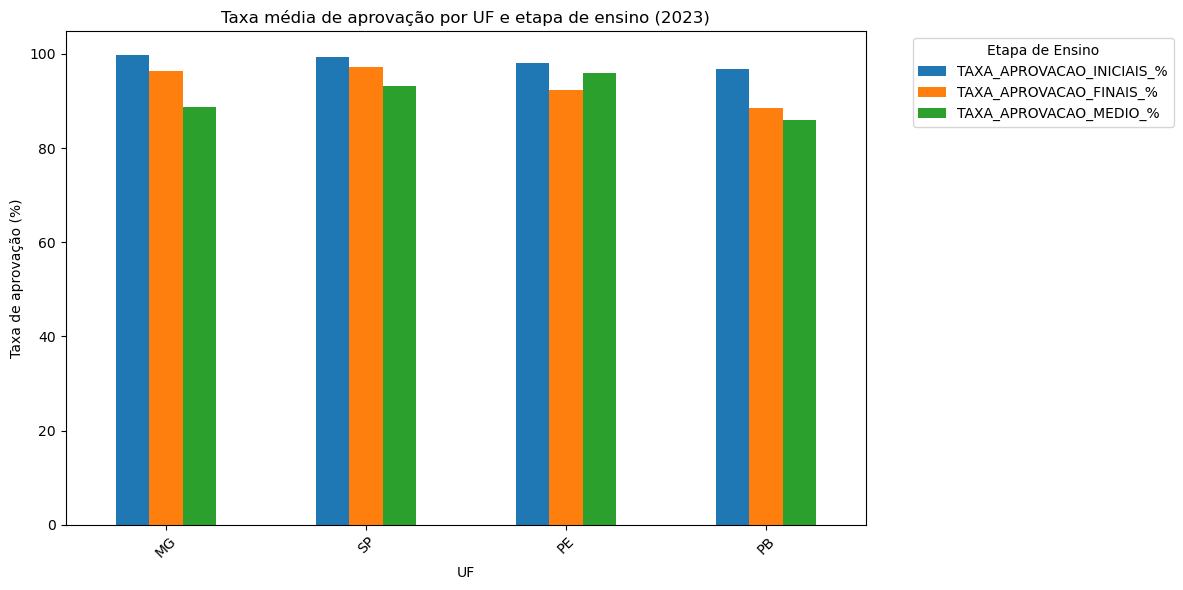

In [14]:
import matplotlib.pyplot as plt

tabela_uf.plot(kind="bar", figsize=(12,6))
plt.title("Taxa média de aprovação por UF e etapa de ensino (2023)")
plt.ylabel("Taxa de aprovação (%)")
plt.xlabel("UF")
plt.xticks(rotation=45)

# Legenda fora do gráfico, no lado direito
plt.legend(title="Etapa de Ensino", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

# Queda normal da média de aprovação ao longo dos anos escolares
# Entretanto, uma diferença perceptível dessa queda no estado da Paraíba


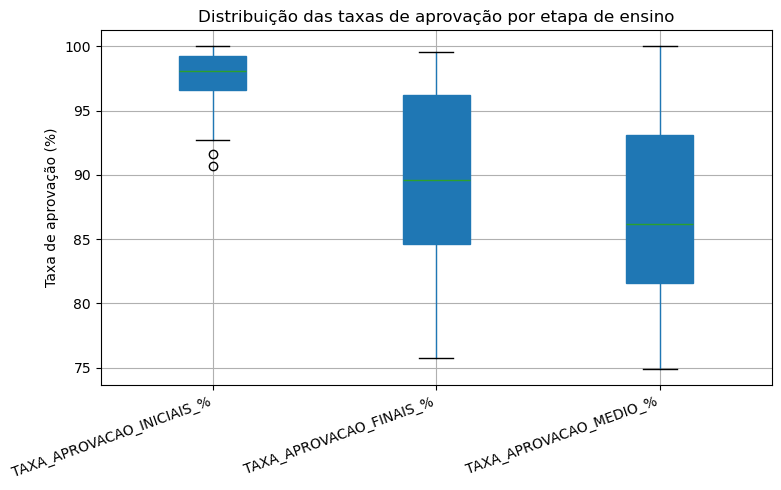

In [15]:
plt.figure(figsize=(8,5))

# Criar o boxplot e capturar o Axes
ax = res[["TAXA_APROVACAO_INICIAIS_%", "TAXA_APROVACAO_FINAIS_%", "TAXA_APROVACAO_MEDIO_%"]].boxplot(
    patch_artist=True,
    return_type='axes'
)

# Definir cores para cada caixa
cores = ["#66c2a5", "#fc8d62", "#8da0cb"]
for patch, cor in zip(ax.artists, cores):
    patch.set_facecolor(cor)

# Ajustar título e rótulos
plt.title("Distribuição das taxas de aprovação por etapa de ensino")
plt.ylabel("Taxa de aprovação (%)")
plt.xticks(rotation=20, ha="right")

plt.tight_layout()
plt.show()

# Percebemos a brusca queda das aprovações com base no nível de dificuldade do ensino
# Aprovação em massa dos anos iniciais, beirando os 100% e queda rápida ao entrar nos anos finais do fundamental e no ensino médio (Quando acontece a maiortaxa de evasão)


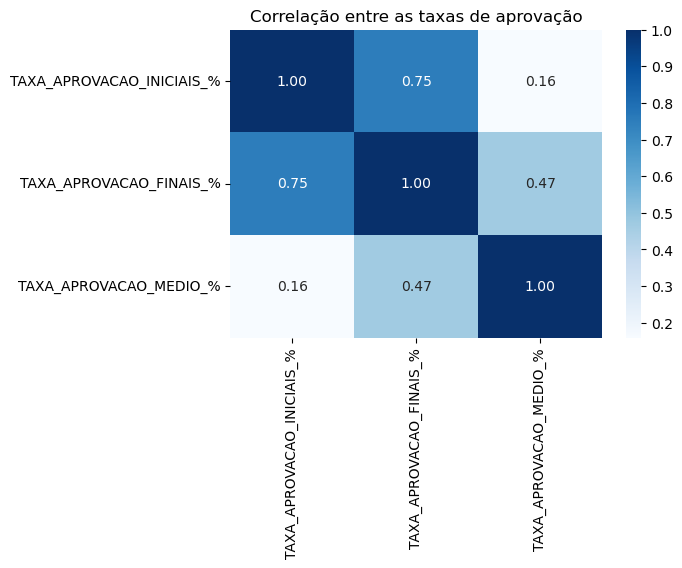

In [16]:
import seaborn as sns

plt.figure(figsize=(6,4))
corr = res[["TAXA_APROVACAO_INICIAIS_%", "TAXA_APROVACAO_FINAIS_%", "TAXA_APROVACAO_MEDIO_%"]].corr()
sns.heatmap(corr, annot=True, cmap="Blues", fmt=".2f")
plt.title("Correlação entre as taxas de aprovação")
plt.show()

# Vemos que a aprovação que mais se correlaciona com as outras é a aprovação dos anos finais
# Também percebemos a baixissima correlação da aprovação dos anos iniciais com o ensino médio, devido ao nível de ambas 

In [17]:
caminho_evasao = r"C:\Users\pedro\OneDrive\Documentos\Análise dados\alpargatas\TX_TRANSICAO_MUNICIPIOS_2021_2022.ods"
df_evasao = pd.read_excel(caminho_evasao, header = 8)


In [18]:
df_evasao.head(10)

,NU_ANO_C+A11+A+A6:A9,NO_REGIAO,NO_UF,CO_MUNICIPIO,NO_MUNICIPIO,NO_LOCALIZACAO,NO_DEPENDENCIA,1_CAT1_CATFUN,1_CAT1_CATFUN_AI,1_CAT1_CATFUN_AF,...,1_CAT4_CATFUN_04,1_CAT4_CATFUN_05,1_CAT4_CATFUN_06,1_CAT4_CATFUN_07,1_CAT4_CATFUN_08,1_CAT4_CATFUN_09,1_CAT4_CATMED,1_CAT4_CATMED_01,1_CAT4_CATMED_02,1_CAT4_CATMED_03
0,2021/2022,Norte,RO,1100015.0,Alta Floresta D'Oeste,Total,Total,92.3,94.3,90.4,...,0,0,0.3,0.4,1.4,1.2,2.3,2.9,3.1,0.4
1,2021/2022,Norte,RO,1100015.0,Alta Floresta D'Oeste,Total,Pública,92.3,94.3,90.4,...,0,0,0.3,0.4,1.4,1.2,2.3,2.9,3.1,0.4
2,2021/2022,Norte,RO,1100015.0,Alta Floresta D'Oeste,Urbana,Total,93.2,95,91.6,...,0,0,0.2,0.6,1.7,1.2,2.2,2.6,3.3,0.4
3,2021/2022,Norte,RO,1100015.0,Alta Floresta D'Oeste,Rural,Total,88,91.1,84.9,...,0,0,0,0,0,1.5,2.1,20,0,0
4,2021/2022,Norte,RO,1100023.0,Ariquemes,Total,Total,89.9,87.3,92.8,...,0.1,0.2,0.5,0.6,1.1,0.8,3.8,2.5,7.3,1.1
5,2021/2022,Norte,RO,1100023.0,Ariquemes,Total,Pública,88.8,85.7,92.2,...,0.1,0.2,0.5,0.7,1.2,0.9,3.9,2.6,7.6,1.1
6,2021/2022,Norte,RO,1100023.0,Ariquemes,Total,Privada,98.5,98.8,98.1,...,0,0,0,0,0,0,0,0,0,0
7,2021/2022,Norte,RO,1100023.0,Ariquemes,Urbana,Total,90.4,87.5,93.6,...,0.1,0.2,0.5,0.6,1.1,0.8,4.4,3.1,8.3,0.6
8,2021/2022,Norte,RO,1100023.0,Ariquemes,Rural,Total,86.2,85.5,86.9,...,0,0,0.4,1,0.4,0.6,1.6,0.2,2.4,2.7
9,2021/2022,Norte,RO,1100031.0,Cabixi,Total,Total,95,94.1,95.9,...,0,0,0,0,0,0,2.1,3,2.9,0


In [19]:
# selecionar apenas as colunas que você quer
colunas_desejadas = [
    "NO_REGIAO",
    "NO_UF",
    "CO_MUNICIPIO",
    "NO_MUNICIPIO",
    "NO_LOCALIZACAO",
    "NO_DEPENDENCIA",
    "1_CAT3_CATFUN",
    "1_CAT3_CATFUN_AI",
    "1_CAT3_CATFUN_01",
    "1_CAT3_CATFUN_02",
    "1_CAT3_CATFUN_03",
    "1_CAT3_CATFUN_04",
    "1_CAT3_CATFUN_05",
    "1_CAT3_CATFUN_06",
    "1_CAT3_CATFUN_07",
    "1_CAT3_CATFUN_08",
    "1_CAT3_CATFUN_09",
    "1_CAT3_CATMED",
    "1_CAT3_CATMED_01",
    "1_CAT3_CATMED_02",
    "1_CAT3_CATMED_03",

]

df_filtrado = df_evasao[colunas_desejadas]
df_filtrado.head(10)


,NO_REGIAO,NO_UF,CO_MUNICIPIO,NO_MUNICIPIO,NO_LOCALIZACAO,NO_DEPENDENCIA,1_CAT3_CATFUN,1_CAT3_CATFUN_AI,1_CAT3_CATFUN_01,1_CAT3_CATFUN_02,...,1_CAT3_CATFUN_04,1_CAT3_CATFUN_05,1_CAT3_CATFUN_06,1_CAT3_CATFUN_07,1_CAT3_CATFUN_08,1_CAT3_CATFUN_09,1_CAT3_CATMED,1_CAT3_CATMED_01,1_CAT3_CATMED_02,1_CAT3_CATMED_03
0,Norte,RO,1100015.0,Alta Floresta D'Oeste,Total,Total,3.8,1.5,0.7,1.4,...,1,2.9,3.2,4.6,5.5,11,13.6,15.4,17.4,6.5
1,Norte,RO,1100015.0,Alta Floresta D'Oeste,Total,Pública,3.8,1.5,0.7,1.4,...,1,2.9,3.2,4.6,5.5,11,13.6,15.4,17.4,6.5
2,Norte,RO,1100015.0,Alta Floresta D'Oeste,Urbana,Total,3.8,1.8,0.9,1.5,...,1.3,3.2,3.4,4.4,5.9,8.7,13.1,14.5,16.8,6.6
3,Norte,RO,1100015.0,Alta Floresta D'Oeste,Rural,Total,4,0.3,0,0,...,0,1.3,2.5,5.1,3.4,21.7,22.4,80,24,5.3
4,Norte,RO,1100023.0,Ariquemes,Total,Total,3.3,2,1.6,1.7,...,2.4,2.4,3.3,3.9,4.5,7.3,10.8,9.6,17.4,4
5,Norte,RO,1100023.0,Ariquemes,Total,Pública,3.6,2.2,1.9,1.9,...,2.5,2.6,3.6,3.9,5.1,7.8,11.1,9.9,18,4.1
6,Norte,RO,1100023.0,Ariquemes,Total,Privada,1.1,0.6,0,0.6,...,1.1,0.6,0.6,3.8,0.4,2.7,1.4,1.8,1.9,0
7,Norte,RO,1100023.0,Ariquemes,Urbana,Total,3,2,1.6,1.7,...,2.4,2.5,3.2,3.3,3.6,6.4,11,9.7,18.4,3
8,Norte,RO,1100023.0,Ariquemes,Rural,Total,5.4,1.7,0.9,0.8,...,1.9,1.9,3.8,7.8,11,14.4,9.9,9.6,12.9,7.4
9,Norte,RO,1100031.0,Cabixi,Total,Total,2.6,1,1.4,0,...,0,0.9,0.9,2,4,8.7,9.8,10.3,16.2,1.7


In [20]:
mapa_colunas = {
    # Fundamental
    "1_CAT3_CATFUN": "Fundamental - Total",
    "1_CAT3_CATFUN_AI": "Fundamental - Anos Iniciais",
    "1_CAT3_CATFUN_AF": "Fundamental - Anos Finais",
    "1_CAT3_CATFUN_01": "Fundamental - 1º Ano",
    "1_CAT3_CATFUN_02": "Fundamental - 2º Ano",
    "1_CAT3_CATFUN_03": "Fundamental - 3º Ano",
    "1_CAT3_CATFUN_04": "Fundamental - 4º Ano",
    "1_CAT3_CATFUN_05": "Fundamental - 5º Ano",
    "1_CAT3_CATFUN_06": "Fundamental - 6º Ano",
    "1_CAT3_CATFUN_07": "Fundamental - 7º Ano",
    "1_CAT3_CATFUN_08": "Fundamental - 8º Ano",
    "1_CAT3_CATFUN_09": "Fundamental - 9º Ano",

    # Médio
    "1_CAT3_CATMED": "Médio - Total",
    "1_CAT3_CATMED_01": "Médio - 1ª série",
    "1_CAT3_CATMED_02": "Médio - 2ª série",
    "1_CAT3_CATMED_03": "Médio - 3ª série",
}

df_filtrado = df_filtrado.rename(columns=mapa_colunas)

df_filtrado.head(16790)


,NO_REGIAO,NO_UF,CO_MUNICIPIO,NO_MUNICIPIO,NO_LOCALIZACAO,NO_DEPENDENCIA,Fundamental - Total,Fundamental - Anos Iniciais,Fundamental - 1º Ano,Fundamental - 2º Ano,...,Fundamental - 4º Ano,Fundamental - 5º Ano,Fundamental - 6º Ano,Fundamental - 7º Ano,Fundamental - 8º Ano,Fundamental - 9º Ano,Médio - Total,Médio - 1ª série,Médio - 2ª série,Médio - 3ª série
0,Norte,RO,1100015.0,Alta Floresta D'Oeste,Total,Total,3.8,1.5,0.7,1.4,...,1,2.9,3.2,4.6,5.5,11,13.6,15.4,17.4,6.5
1,Norte,RO,1100015.0,Alta Floresta D'Oeste,Total,Pública,3.8,1.5,0.7,1.4,...,1,2.9,3.2,4.6,5.5,11,13.6,15.4,17.4,6.5
2,Norte,RO,1100015.0,Alta Floresta D'Oeste,Urbana,Total,3.8,1.8,0.9,1.5,...,1.3,3.2,3.4,4.4,5.9,8.7,13.1,14.5,16.8,6.6
3,Norte,RO,1100015.0,Alta Floresta D'Oeste,Rural,Total,4,0.3,0,0,...,0,1.3,2.5,5.1,3.4,21.7,22.4,80,24,5.3
4,Norte,RO,1100023.0,Ariquemes,Total,Total,3.3,2,1.6,1.7,...,2.4,2.4,3.3,3.9,4.5,7.3,10.8,9.6,17.4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16785,Sudeste,SP,3553302.0,Tambaú,Urbana,Total,0.8,0.2,0,0,...,0,0.3,1,1.1,0.8,3.8,8.9,12.5,9.9,3.1
16786,Sudeste,SP,3553302.0,Tambaú,Rural,Total,0,0,0,0,...,0,0,--,--,--,--,--,--,--,--
16787,Sudeste,SP,3553401.0,Tanabi,Total,Total,1.2,0.1,0,0.3,...,0,0.3,1.3,0.9,1.6,6.2,8.7,10.7,14.7,0
16788,Sudeste,SP,3553401.0,Tanabi,Total,Pública,1.4,0.1,0,0.4,...,0,0.3,1.2,1.1,2.1,8,10.4,13,17.6,0


In [21]:
# garantir que as taxas são numéricas
for col in ["Fundamental - Total", "Médio - Total"]:
    df_filtrado[col] = pd.to_numeric(
        df_filtrado[col].astype(str).str.replace(",", "."), errors="coerce"
    )

# maior taxa no Fundamental
mais_alto_fund = df_filtrado.loc[df_filtrado["Fundamental - Total"].idxmax(),
                               ["NO_MUNICIPIO", "Fundamental - Total", "Médio - Total"]]

# maior taxa no Médio
mais_alto_med = df_filtrado.loc[df_filtrado["Médio - Total"].idxmax(),
                              ["NO_MUNICIPIO", "Fundamental - Total", "Médio - Total"]]
# ordenar por Fundamental (do maior para o menor)
ranking_fund = df_filtrado.sort_values("Fundamental - Total", ascending=False)[
    ["NO_MUNICIPIO", "Fundamental - Total", "Médio - Total"]
]

# ordenar por Médio (do maior para o menor)
ranking_med = df_filtrado.sort_values("Médio - Total", ascending=False)[
    ["NO_MUNICIPIO", "Fundamental - Total", "Médio - Total"]
]

print("🔹 Ranking completo - Fundamental")
display(ranking_fund)

print("🔹 Ranking completo - Médio")
display(ranking_med)



🔹 Ranking completo - Fundamental


,NO_MUNICIPIO,Fundamental - Total,Médio - Total
15834,Mogi Mirim,75.7,71.4
16791,Tanabi,75.0,100.0
14947,Caraguatatuba,71.4,61.5
15811,Mirassol,65.4,5.5
16806,Taquaritinga,64.3,60.0
...,...,...,...
23680,Uirapuru,NaN,10.9
23693,Urutaí,NaN,7.4
23722,NaN,NaN,NaN
23723,NaN,NaN,NaN


🔹 Ranking completo - Médio


,NO_MUNICIPIO,Fundamental - Total,Médio - Total
16791,Tanabi,75.0,100.0
10045,Teixeira de Freitas,6.3,89.6
13409,Sete Lagoas,3.9,84.6
3634,Porto,7.9,75.0
16373,Ribeirão Preto,56.8,75.0
...,...,...,...
23705,Vianópolis,3.7,NaN
23712,Vila Boa,0.0,NaN
23722,NaN,NaN,NaN
23723,NaN,NaN,NaN


In [22]:
import pandas as pd

# 1) Forçar numérico (se vier string ou float com .0)
res["MUNICIPIO_CODIGO"]     = pd.to_numeric(res["MUNICIPIO_CODIGO"], errors="coerce")
df_filtrado["CO_MUNICIPIO"] = pd.to_numeric(df_filtrado["CO_MUNICIPIO"], errors="coerce")

# 2) Usar inteiro que aceita nulos
res["MUNICIPIO_CODIGO"]     = res["MUNICIPIO_CODIGO"].astype("Int64")
df_filtrado["CO_MUNICIPIO"] = df_filtrado["CO_MUNICIPIO"].astype("Int64")

# 3) Eliminar linhas sem código
res_ok        = res.dropna(subset=["MUNICIPIO_CODIGO"]).copy()
df_filtrado_ok = df_filtrado.dropna(subset=["CO_MUNICIPIO"]).copy()

# (opcional) criar código IBGE como string de 7 dígitos
res_ok["COD_IBGE"]        = res_ok["MUNICIPIO_CODIGO"].astype("Int64").astype(str).str.zfill(7)
df_filtrado_ok["COD_IBGE"] = df_filtrado_ok["CO_MUNICIPIO"].astype("Int64").astype(str).str.zfill(7)

# mesmas etapas de merge que já fizemos antes...
df_merge = pd.merge(
    res_ok,
    df_filtrado_ok,
    left_on="MUNICIPIO_CODIGO",
    right_on="CO_MUNICIPIO",
    how="inner"
)

# agora seleciona as colunas principais + localização e dependência
cols_saida = [
    "COD_IBGE", 
    "UF_SIGLA", 
    "MUNICIPIO_NOME_ALP", 
    "NO_MUNICIPIO",
    "NO_LOCALIZACAO",          # vem do df_filtrado
    "NO_DEPENDENCIA",          # vem do df_filtrado
    "Fundamental - Total", 
    "Médio - Total",
    "TAXA_APROVACAO_INICIAIS", 
    "TAXA_APROVACAO_FINAIS"
]

# pega só as colunas que realmente existem no df
cols_saida = [c for c in cols_saida if c in df_merge.columns]
resultado = df_merge[cols_saida].copy()

# visualizar os 10 primeiros
resultado.rename(columns={"Fundamental - Total": "Evasão - Fundamental", "Médio - Total": "Evasão -Médio"}, inplace=True)
resultado.head(30)



,UF_SIGLA,MUNICIPIO_NOME_ALP,NO_MUNICIPIO,NO_LOCALIZACAO,NO_DEPENDENCIA,Evasão - Fundamental,Evasão -Médio,TAXA_APROVACAO_INICIAIS,TAXA_APROVACAO_FINAIS
0,PB,ALAGOA NOVA,Alagoa Nova,Total,Total,2.7,9.3,0.9703,0.8187
1,PB,ALAGOA NOVA,Alagoa Nova,Total,Pública,2.8,9.3,0.9703,0.8187
2,PB,ALAGOA NOVA,Alagoa Nova,Total,Privada,1.2,NaN,0.9703,0.8187
3,PB,ALAGOA NOVA,Alagoa Nova,Urbana,Total,2.9,9.3,0.9703,0.8187
4,PB,ALAGOA NOVA,Alagoa Nova,Rural,Total,2.4,NaN,0.9703,0.8187
5,PB,BAÍA DA TRAIÇÃO,Baía da Traição,Total,Total,3.2,6.6,0.9066,0.8661
6,PB,BAÍA DA TRAIÇÃO,Baía da Traição,Total,Pública,3.2,6.6,0.9066,0.8661
7,PB,BAÍA DA TRAIÇÃO,Baía da Traição,Urbana,Total,2.8,2.3,0.9066,0.8661
8,PB,BAÍA DA TRAIÇÃO,Baía da Traição,Rural,Total,3.4,8.9,0.9066,0.8661
9,PB,BANANEIRAS,Bananeiras,Total,Total,3.6,17.0,0.9713,0.8612


In [23]:
# Tratamento de outliers
num_cols = [
    "Evasão - Fundamental", 
    "Evasão -Médio", 
    "TAXA_APROVACAO_INICIAIS", 
    "TAXA_APROVACAO_FINAIS"
]

num_cols = [c for c in num_cols if c in resultado.columns]

# 2) coerção robusta para numérico
resultado_num = resultado.copy()
for col in num_cols:
    # troca vírgula por ponto e converte; valores não-numéricos viram NaN
    resultado_num[col] = (
        resultado_num[col]
        .astype(str)
        .str.replace(",", ".", regex=False)
        .str.replace("%", "", regex=False)
        .str.replace("\u2212", "-", regex=False)  # sinal de menos unicode, se houver
    )
    resultado_num[col] = pd.to_numeric(resultado_num[col], errors="coerce")

# 3) IQR
Q1 = resultado_num[num_cols].quantile(0.25, numeric_only=True)
Q3 = resultado_num[num_cols].quantile(0.75, numeric_only=True)
IQR = Q3 - Q1
low  = Q1 - 1.5 * IQR
high = Q3 + 1.5 * IQR

mask_out = (resultado_num[num_cols] < low) | (resultado_num[num_cols] > high)
outliers_df = resultado_num[mask_out.any(axis=1)].copy()
sem_outliers_df = resultado_num[~mask_out.any(axis=1)].copy()

# 4) Winsorização (cap) — limita aos limites low/high por coluna
winsor_df = resultado_num.copy()
for col in num_cols:
    winsor_df[col] = winsor_df[col].clip(lower=low[col], upper=high[col])

# 5) ver resultados
print("▶ Colunas tratadas:", num_cols)
print("▶ Linhas (orig / outliers / sem_outliers):", len(resultado), len(outliers_df), len(sem_outliers_df))

display(outliers_df.head(10))       # mostra quem são os casos problemáticos que merecem atenção individual.
display(sem_outliers_df.head(10))   # mostra como se comporta a regra geral (análise limpa, tendência central).
display(winsor_df.head(10))         # mantém todos os municípios, mas corrige os extremos para que análises estatísticas fiquem mais robustas.

▶ Colunas tratadas: ['Evasão - Fundamental', 'Evasão -Médio', 'TAXA_APROVACAO_INICIAIS', 'TAXA_APROVACAO_FINAIS']
▶ Linhas (orig / outliers / sem_outliers): 87 9 78


,UF_SIGLA,MUNICIPIO_NOME_ALP,NO_MUNICIPIO,NO_LOCALIZACAO,NO_DEPENDENCIA,Evasão - Fundamental,Evasão -Médio,TAXA_APROVACAO_INICIAIS,TAXA_APROVACAO_FINAIS
5,PB,BAÍA DA TRAIÇÃO,Baía da Traição,Total,Total,3.2,6.6,0.9066,0.8661
6,PB,BAÍA DA TRAIÇÃO,Baía da Traição,Total,Pública,3.2,6.6,0.9066,0.8661
7,PB,BAÍA DA TRAIÇÃO,Baía da Traição,Urbana,Total,2.8,2.3,0.9066,0.8661
8,PB,BAÍA DA TRAIÇÃO,Baía da Traição,Rural,Total,3.4,8.9,0.9066,0.8661
82,PB,SERRA REDONDA,Serra Redonda,Total,Total,5.8,13.6,0.9162,0.7574
83,PB,SERRA REDONDA,Serra Redonda,Total,Pública,6.1,13.6,0.9162,0.7574
84,PB,SERRA REDONDA,Serra Redonda,Total,Privada,2.7,NaN,0.9162,0.7574
85,PB,SERRA REDONDA,Serra Redonda,Urbana,Total,7.2,13.6,0.9162,0.7574
86,PB,SERRA REDONDA,Serra Redonda,Rural,Total,1.1,NaN,0.9162,0.7574


,UF_SIGLA,MUNICIPIO_NOME_ALP,NO_MUNICIPIO,NO_LOCALIZACAO,NO_DEPENDENCIA,Evasão - Fundamental,Evasão -Médio,TAXA_APROVACAO_INICIAIS,TAXA_APROVACAO_FINAIS
0,PB,ALAGOA NOVA,Alagoa Nova,Total,Total,2.7,9.3,0.9703,0.8187
1,PB,ALAGOA NOVA,Alagoa Nova,Total,Pública,2.8,9.3,0.9703,0.8187
2,PB,ALAGOA NOVA,Alagoa Nova,Total,Privada,1.2,NaN,0.9703,0.8187
3,PB,ALAGOA NOVA,Alagoa Nova,Urbana,Total,2.9,9.3,0.9703,0.8187
4,PB,ALAGOA NOVA,Alagoa Nova,Rural,Total,2.4,NaN,0.9703,0.8187
9,PB,BANANEIRAS,Bananeiras,Total,Total,3.6,17.0,0.9713,0.8612
10,PB,BANANEIRAS,Bananeiras,Total,Pública,4.2,18.1,0.9713,0.8612
11,PB,BANANEIRAS,Bananeiras,Total,Privada,1.1,2.3,0.9713,0.8612
12,PB,BANANEIRAS,Bananeiras,Urbana,Total,3.5,18.2,0.9713,0.8612
13,PB,BANANEIRAS,Bananeiras,Rural,Total,3.6,7.4,0.9713,0.8612


,UF_SIGLA,MUNICIPIO_NOME_ALP,NO_MUNICIPIO,NO_LOCALIZACAO,NO_DEPENDENCIA,Evasão - Fundamental,Evasão -Médio,TAXA_APROVACAO_INICIAIS,TAXA_APROVACAO_FINAIS
0,PB,ALAGOA NOVA,Alagoa Nova,Total,Total,2.7,9.3,0.97030,0.8187
1,PB,ALAGOA NOVA,Alagoa Nova,Total,Pública,2.8,9.3,0.97030,0.8187
2,PB,ALAGOA NOVA,Alagoa Nova,Total,Privada,1.2,NaN,0.97030,0.8187
3,PB,ALAGOA NOVA,Alagoa Nova,Urbana,Total,2.9,9.3,0.97030,0.8187
4,PB,ALAGOA NOVA,Alagoa Nova,Rural,Total,2.4,NaN,0.97030,0.8187
5,PB,BAÍA DA TRAIÇÃO,Baía da Traição,Total,Total,3.2,6.6,0.92035,0.8661
6,PB,BAÍA DA TRAIÇÃO,Baía da Traição,Total,Pública,3.2,6.6,0.92035,0.8661
7,PB,BAÍA DA TRAIÇÃO,Baía da Traição,Urbana,Total,2.8,2.3,0.92035,0.8661
8,PB,BAÍA DA TRAIÇÃO,Baía da Traição,Rural,Total,3.4,8.9,0.92035,0.8661
9,PB,BANANEIRAS,Bananeiras,Total,Total,3.6,17.0,0.97130,0.8612


In [24]:
winsor_df["Reprovacao_Iniciais"] = (1 - winsor_df["TAXA_APROVACAO_INICIAIS"]) * 100
winsor_df["Reprovacao_Finais"]   = (1 - winsor_df["TAXA_APROVACAO_FINAIS"]) * 100

winsor_df["Urgencia"] = (
    winsor_df["Evasão - Fundamental"] +
    winsor_df["Evasão -Médio"] +
    winsor_df["Reprovacao_Iniciais"] +
    winsor_df["Reprovacao_Finais"]
)

urgentes = winsor_df.sort_values("Urgencia", ascending=False).head(20)
display(urgentes)



,UF_SIGLA,MUNICIPIO_NOME_ALP,NO_MUNICIPIO,NO_LOCALIZACAO,NO_DEPENDENCIA,Evasão - Fundamental,Evasão -Médio,TAXA_APROVACAO_INICIAIS,TAXA_APROVACAO_FINAIS,Reprovacao_Iniciais,Reprovacao_Finais,Urgencia
85,PB,SERRA REDONDA,Serra Redonda,Urbana,Total,6.15,13.6,0.92035,0.7574,7.965,24.26,51.975
83,PB,SERRA REDONDA,Serra Redonda,Total,Pública,6.10,13.6,0.92035,0.7574,7.965,24.26,51.925
82,PB,SERRA REDONDA,Serra Redonda,Total,Total,5.80,13.6,0.92035,0.7574,7.965,24.26,51.625
73,PB,SANTA RITA,Santa Rita,Total,Pública,5.50,15.2,0.92710,0.8197,7.290,18.03,46.020
72,PB,SANTA RITA,Santa Rita,Total,Total,5.00,14.5,0.92710,0.8197,7.290,18.03,44.820
76,PB,SANTA RITA,Santa Rita,Rural,Total,5.90,13.4,0.92710,0.8197,7.290,18.03,44.620
75,PB,SANTA RITA,Santa Rita,Urbana,Total,4.70,14.5,0.92710,0.8197,7.290,18.03,44.520
10,PB,BANANEIRAS,Bananeiras,Total,Pública,4.20,18.1,0.97130,0.8612,2.870,13.88,39.050
12,PB,BANANEIRAS,Bananeiras,Urbana,Total,3.50,18.2,0.97130,0.8612,2.870,13.88,38.450
9,PB,BANANEIRAS,Bananeiras,Total,Total,3.60,17.0,0.97130,0.8612,2.870,13.88,37.350


In [25]:
# Escolha as colunas que você quer no app:
colunas_essenciais = [
    "MUNICIPIO_NOME_ALP",   # ou "NO_MUNICIPIO"
    "NO_LOCALIZACAO",       # opcional
    "NO_DEPENDENCIA",       # opcional
    "Evasão - Fundamental",
    "Evasão -Médio",
    "TAXA_APROVACAO_INICIAIS",
    "TAXA_APROVACAO_FINAIS",
    "Reprovacao_Iniciais",
    "Reprovacao_Finais",
    "Urgencia"
]

tabela_essencial = urgentes[colunas_essenciais].copy()  # use o seu DF final (ex.: winsor_df / urgentes)

# Garanta que números estão no formato numérico:
def to_num(s):
    return pd.to_numeric(s.astype(str).str.replace(",", ".", regex=False), errors="coerce")

for c in ["Evasão - Fundamental", "Evasão - Médio",
          "TAXA_APROVACAO_INICIAIS", "TAXA_APROVACAO_FINAIS",
          "Reprovacao_Iniciais", "Reprovacao_Finais", "Urgencia"]:
    if c in tabela_essencial.columns:
        tabela_essencial[c] = to_num(tabela_essencial[c])

# Salvar como Excel e CSV
tabela_essencial.to_excel("tabela_essencial.xlsx", index=False)
tabela_essencial.to_csv("tabela_essencial.csv", index=False, encoding="utf-8")
print("Arquivos salvos: tabela_essencial.xlsx e tabela_essencial.csv")


Arquivos salvos: tabela_essencial.xlsx e tabela_essencial.csv


In [26]:
import unicodedata
import pandas as pd

# ============================================================
# Funções utilitárias
# ============================================================
def nrm(x):
    if pd.isna(x):
        return ""
    s = str(x)
    s = unicodedata.normalize("NFKD", s).encode("ASCII", "ignore").decode("ASCII")
    return s.upper().strip()

def chave_municipio(nome: str) -> str:
    n = nrm(nome).replace("–", "-").replace("—", "-")
    if " - " in n:
        n = n.split(" - ")[0]
    for suf in (" MIXING CENTER", " DISTRITO", " DISTRITO INDUSTRIAL"):
        if n.endswith(suf):
            n = n[: -len(suf)].strip()
    return n

def ensure_key_urgentes(urgentes: pd.DataFrame) -> pd.DataFrame:
    u = urgentes.copy()
    # prioridade: MUNICIPIO_NOME_ALP → se não tiver, usa NO_MUNICIPIO
    if "MUNICIPIO_NOME_ALP" in u.columns:
        base_nome = u["MUNICIPIO_NOME_ALP"].where(
            u["MUNICIPIO_NOME_ALP"].notna(),
            u.get("NO_MUNICIPIO")
        )
    else:
        base_nome = u.get("NO_MUNICIPIO")
    u["MUNICIPIO_CHAVE"] = base_nome.apply(chave_municipio)
    return u

# ============================================================
# 0) Look-up UF por código IBGE (usa sua DTB)
# ============================================================
dtb = carrega_dtb(ARQ_DTB)  # do seu sprint01.py
dtb_lookup = (
    dtb[["MUNICIPIO_CODIGO", "UF_SIGLA", "MUNICIPIO_NOME"]]
      .rename(columns={"MUNICIPIO_CODIGO": "CO_MUNICIPIO"})
)
dtb_lookup["CO_MUNICIPIO"] = (
    dtb_lookup["CO_MUNICIPIO"].astype(str).str.extract(r"(\d{7})", expand=False).str.zfill(7)
)

# ============================================================
# 1) média dos OUTROS anos (≠ 2023) por município (anexa UF via DTB)
# ============================================================
def media_outros_anos_nome_uf(df: pd.DataFrame, rotulo_saida: str) -> pd.DataFrame:
    anos = [2005, 2007, 2009, 2011, 2013, 2015, 2017, 2019, 2021, 2022]
    cols = [f"VL_INDICADOR_REND_{a}" for a in anos if f"VL_INDICADOR_REND_{a}" in df.columns]
    if not cols:
        raise KeyError("Nenhuma coluna VL_INDICADOR_REND_XXXX (anos ≠ 2023) encontrada.")

    tmp = df.copy()
    tmp["CO_MUNICIPIO"] = (
        tmp["CO_MUNICIPIO"].astype(str).str.extract(r"(\d{7})", expand=False).str.zfill(7)
    )

    # anexa UF e nome oficial via DTB
    tmp = tmp.merge(dtb_lookup, on="CO_MUNICIPIO", how="left")

    # cria chave por NOME para casar com 'urgentes'
    nome_base = tmp["NO_MUNICIPIO"].where(tmp["NO_MUNICIPIO"].notna(), tmp["MUNICIPIO_NOME"])
    tmp["MUNICIPIO_CHAVE"] = nome_base.apply(chave_municipio)

    # calcula média histórica
    tmp_num = tmp[cols].apply(pd.to_numeric, errors="coerce")
    tmp[rotulo_saida] = tmp_num.mean(axis=1, skipna=True)

    out = (tmp.groupby(["UF_SIGLA", "MUNICIPIO_CHAVE"], as_index=False)[rotulo_saida]
             .mean())
    return out

# ============================================================
# 2) calcula históricos (iniciais/finais/médio) e média geral
# ============================================================
ini_hist = media_outros_anos_nome_uf(df_iniciais, "TAXA_APROVACAO_INICIAIS_HIST")
fin_hist = media_outros_anos_nome_uf(df_finais,   "TAXA_APROVACAO_FINAIS_HIST")
med_hist = media_outros_anos_nome_uf(df_em,       "TAXA_APROVACAO_MEDIO_HIST")

hist = (ini_hist.merge(fin_hist, on=["UF_SIGLA","MUNICIPIO_CHAVE"], how="outer")
               .merge(med_hist, on=["UF_SIGLA","MUNICIPIO_CHAVE"], how="outer"))

hist["TAXA_APROVACAO_MEDIA_HIST"] = hist[
    ["TAXA_APROVACAO_INICIAIS_HIST","TAXA_APROVACAO_FINAIS_HIST","TAXA_APROVACAO_MEDIO_HIST"]
].mean(axis=1)

for c in ["TAXA_APROVACAO_INICIAIS_HIST","TAXA_APROVACAO_FINAIS_HIST","TAXA_APROVACAO_MEDIO_HIST","TAXA_APROVACAO_MEDIA_HIST"]:
    if c in hist.columns: 
        hist[c] = hist[c].round(4)

hist["TAXA_APROVACAO_MEDIA_HIST_%"] = (hist["TAXA_APROVACAO_MEDIA_HIST"]*100).round(2)

# ============================================================
# 3) garante chave em 'urgentes' e faz o merge por UF+chave
# ============================================================
urgentes = ensure_key_urgentes(urgentes)
urgentes = urgentes.merge(
    hist[["UF_SIGLA","MUNICIPIO_CHAVE","TAXA_APROVACAO_MEDIA_HIST","TAXA_APROVACAO_MEDIA_HIST_%"]],
    on=["UF_SIGLA","MUNICIPIO_CHAVE"],
    how="left"
)



In [27]:
urgentes.drop(columns=["TAXA_APROVACAO_MEDIA_HIST", "MUNICIPIO_CHAVE"], errors="ignore", inplace=True)
urgentes = urgentes.rename(columns={"TAXA_APROVACAO_MEDIA_HIST_%": "MÉDIA_HISTÓRICA"})
display(urgentes.head(20))

,UF_SIGLA,MUNICIPIO_NOME_ALP,NO_MUNICIPIO,NO_LOCALIZACAO,NO_DEPENDENCIA,Evasão - Fundamental,Evasão -Médio,TAXA_APROVACAO_INICIAIS,TAXA_APROVACAO_FINAIS,Reprovacao_Iniciais,Reprovacao_Finais,Urgencia,MÉDIA_HISTÓRICA
0,PB,SERRA REDONDA,Serra Redonda,Urbana,Total,6.15,13.6,0.92035,0.7574,7.965,24.26,51.975,77.64
1,PB,SERRA REDONDA,Serra Redonda,Total,Pública,6.10,13.6,0.92035,0.7574,7.965,24.26,51.925,77.64
2,PB,SERRA REDONDA,Serra Redonda,Total,Total,5.80,13.6,0.92035,0.7574,7.965,24.26,51.625,77.64
3,PB,SANTA RITA,Santa Rita,Total,Pública,5.50,15.2,0.92710,0.8197,7.290,18.03,46.020,78.37
4,PB,SANTA RITA,Santa Rita,Total,Total,5.00,14.5,0.92710,0.8197,7.290,18.03,44.820,78.37
5,PB,SANTA RITA,Santa Rita,Rural,Total,5.90,13.4,0.92710,0.8197,7.290,18.03,44.620,78.37
6,PB,SANTA RITA,Santa Rita,Urbana,Total,4.70,14.5,0.92710,0.8197,7.290,18.03,44.520,78.37
7,PB,BANANEIRAS,Bananeiras,Total,Pública,4.20,18.1,0.97130,0.8612,2.870,13.88,39.050,79.88
8,PB,BANANEIRAS,Bananeiras,Urbana,Total,3.50,18.2,0.97130,0.8612,2.870,13.88,38.450,79.88
9,PB,BANANEIRAS,Bananeiras,Total,Total,3.60,17.0,0.97130,0.8612,2.870,13.88,37.350,79.88


In [28]:
import re 

# ===========================
# 0) Lookup: UF e nome oficial via DTB
# ===========================
dtb = carrega_dtb(ARQ_DTB)  # já existe no seu sprint01.py
dtb_lookup = (
    dtb[["MUNICIPIO_CODIGO", "UF_SIGLA", "MUNICIPIO_NOME"]]
      .rename(columns={"MUNICIPIO_CODIGO": "CO_MUNICIPIO"})
      .copy()
)
dtb_lookup["CO_MUNICIPIO"] = (
    dtb_lookup["CO_MUNICIPIO"].astype(str).str.extract(r"(\d{7})", expand=False).str.zfill(7)
)

# ===========================
# 1) Utilitários
# ===========================
def _anos_disponiveis(df: pd.DataFrame, ano_min=2005, ano_max=2023) -> list[int]:
    """Detecta automaticamente os anos que existem como VL_INDICADOR_REND_YYYY dentro do range dado."""
    anos = []
    for c in df.columns:
        m = re.fullmatch(r"VL_INDICADOR_REND_(\d{4})", str(c))
        if m:
            a = int(m.group(1))
            if ano_min <= a <= ano_max:
                anos.append(a)
    return sorted(set(anos))

def _long_por_municipio_ano(df: pd.DataFrame, etapa_rotulo: str) -> pd.DataFrame:
    """
    Converte uma planilha (iniciais/finais/médio) para formato longo:
    colunas: CO_MUNICIPIO, ANO, <etapa_rotulo>
    Onde <etapa_rotulo> é a taxa (proporção 0–1) da etapa naquele ano.
    """
    df = df.copy()
    if "CO_MUNICIPIO" not in df.columns:
        raise KeyError("Planilha não possui CO_MUNICIPIO.")
    df["CO_MUNICIPIO"] = (
        df["CO_MUNICIPIO"].astype(str).str.extract(r"(\d{7})", expand=False).str.zfill(7)
    )

    anos = _anos_disponiveis(df, 2005, 2023)
    if not anos:
        raise KeyError("Nenhuma coluna VL_INDICADOR_REND_YYYY encontrada no intervalo 2005–2023.")

    cols = [f"VL_INDICADOR_REND_{a}" for a in anos]
    num = df[["CO_MUNICIPIO"] + cols].copy()
    for c in cols:
        num[c] = pd.to_numeric(num[c], errors="coerce")

    # wide -> long
    long_df = num.melt(id_vars="CO_MUNICIPIO", value_vars=cols,
                       var_name="COL", value_name=etapa_rotulo)
    long_df["ANO"] = long_df["COL"].str.extract(r"(\d{4})").astype(int)
    long_df = long_df.drop(columns=["COL"])

    # média por município-ano (caso existam múltiplas linhas por município)
    long_grp = (long_df
                .groupby(["CO_MUNICIPIO", "ANO"], as_index=False)[etapa_rotulo]
                .mean())
    return long_grp

# ===========================
# 2) Construção das três séries (iniciais/finais/médio)
# ===========================
evo_ini = _long_por_municipio_ano(df_iniciais, "APROVACAO_INICIAIS")
evo_fin = _long_por_municipio_ano(df_finais,   "APROVACAO_FINAIS")
evo_med = _long_por_municipio_ano(df_em,       "APROVACAO_MEDIO")

# ===========================
# 3) Merge por município + ano e média geral
# ===========================
evolucao = (evo_ini
            .merge(evo_fin, on=["CO_MUNICIPIO","ANO"], how="outer")
            .merge(evo_med, on=["CO_MUNICIPIO","ANO"], how="outer"))

# média simples entre as etapas disponíveis (ignora NaN)
evolucao["APROVACAO_MEDIA_GERAL"] = evolucao[
    ["APROVACAO_INICIAIS", "APROVACAO_FINAIS", "APROVACAO_MEDIO"]
].mean(axis=1, skipna=True)

# versões em porcentagem
for c in ["APROVACAO_INICIAIS","APROVACAO_FINAIS","APROVACAO_MEDIO","APROVACAO_MEDIA_GERAL"]:
    evolucao[c + "_%"] = (evolucao[c] * 100).round(2)

# ===========================
# 4) Anexar UF e nome oficial (para facilitar gráficos/relatórios)
# ===========================
evolucao = evolucao.merge(dtb_lookup, on="CO_MUNICIPIO", how="left")

# ordenar e colunas finais
cols_out = [
    "UF_SIGLA","MUNICIPIO_NOME","CO_MUNICIPIO","ANO",
    "APROVACAO_INICIAIS","APROVACAO_FINAIS","APROVACAO_MEDIO","APROVACAO_MEDIA_GERAL",
    "APROVACAO_INICIAIS_%","APROVACAO_FINAIS_%","APROVACAO_MEDIO_%","APROVACAO_MEDIA_GERAL_%",
]
evolucao = evolucao[cols_out].sort_values(["UF_SIGLA","MUNICIPIO_NOME","ANO"]).reset_index(drop=True)


In [29]:
# ============================================================
# 5) Filtrar apenas municípios presentes em URGENTES
# ============================================================

# garante que urgentes tem MUNICIPIO_CHAVE e UF_SIGLA
urgentes = ensure_key_urgentes(urgentes)

# cria chave também na tabela evolucao
evolucao["MUNICIPIO_CHAVE"] = evolucao["MUNICIPIO_NOME"].apply(chave_municipio)

# filtra: mantém só os municípios que estão na tabela urgentes
evolucao_filtrada = evolucao.merge(
    urgentes[["UF_SIGLA","MUNICIPIO_CHAVE"]].drop_duplicates(),
    on=["UF_SIGLA","MUNICIPIO_CHAVE"],
    how="inner"
).sort_values(["UF_SIGLA","MUNICIPIO_NOME","ANO"]).reset_index(drop=True)



In [30]:
# ============================================================
# 6) Preencher valores NaN pela mediana dos outros anos (por município)
# ============================================================

# colunas numéricas que queremos corrigir
cols_num = [
    "APROVACAO_INICIAIS","APROVACAO_FINAIS","APROVACAO_MEDIO","APROVACAO_MEDIA_GERAL",
    "APROVACAO_INICIAIS_%","APROVACAO_FINAIS_%","APROVACAO_MEDIO_%","APROVACAO_MEDIA_GERAL_%"
]

# aplica mediana por município (MUNICIPIO_CHAVE)
def preencher_por_mediana(df, grupo="MUNICIPIO_CHAVE", cols=cols_num):
    df = df.copy()
    for col in cols:
        if col not in df.columns:
            continue
        df[col] = df.groupby(grupo)[col].transform(
            lambda x: x.fillna(x.median(skipna=True))
        )
    return df

# aplica na tabela evolucao_filtrada
evolucao_filtrada = preencher_por_mediana(evolucao_filtrada)

# conferindo se ainda restam NaN
evolucao_filtrada.head(20)


,UF_SIGLA,MUNICIPIO_NOME,CO_MUNICIPIO,ANO,APROVACAO_INICIAIS,APROVACAO_FINAIS,APROVACAO_MEDIO,APROVACAO_MEDIA_GERAL,APROVACAO_INICIAIS_%,APROVACAO_FINAIS_%,APROVACAO_MEDIO_%,APROVACAO_MEDIA_GERAL_%,MUNICIPIO_CHAVE
0,PB,BANANEIRAS,2501500,2005,0.649716,0.522871,0.809665,0.586293,64.97,52.29,80.965,58.63,BANANEIRAS
1,PB,BANANEIRAS,2501500,2007,0.745467,0.651521,0.809665,0.698494,74.55,65.15,80.965,69.85,BANANEIRAS
2,PB,BANANEIRAS,2501500,2009,0.810568,0.712461,0.809665,0.761515,81.06,71.25,80.965,76.15,BANANEIRAS
3,PB,BANANEIRAS,2501500,2011,0.912879,0.698315,0.809665,0.805597,91.29,69.83,80.965,80.56,BANANEIRAS
4,PB,BANANEIRAS,2501500,2013,0.910634,0.792310,0.809665,0.851472,91.06,79.23,80.965,85.15,BANANEIRAS
5,PB,BANANEIRAS,2501500,2015,0.918559,0.756145,0.809665,0.837352,91.86,75.61,80.965,83.74,BANANEIRAS
6,PB,BANANEIRAS,2501500,2017,0.900842,0.702206,0.722256,0.775101,90.08,70.22,72.230,77.51,BANANEIRAS
7,PB,BANANEIRAS,2501500,2019,0.922731,0.718903,0.832523,0.824719,92.27,71.89,83.250,82.47,BANANEIRAS
8,PB,BANANEIRAS,2501500,2021,0.982386,0.950037,0.906621,0.946348,98.24,95.00,90.660,94.63,BANANEIRAS
9,PB,BANANEIRAS,2501500,2023,0.971324,0.861160,0.786807,0.873097,97.13,86.12,78.680,87.31,BANANEIRAS


**ANÁLISE**

**2- O problema**


In [31]:
top10 = (urgentes.groupby("NO_MUNICIPIO")["Urgencia"]
                 .mean()
                 .sort_values(ascending=False)
                 .head(10))
display(top10)


NO_MUNICIPIO
Serra Redonda      51.841667
Santa Rita         44.995000
Bananeiras         38.283333
João Pessoa        36.355000
Ingá               35.270000
Caturité           34.273333
Baía da Traição    33.655000
Campina Grande     33.650000
Name: Urgencia, dtype: float64

C:\Users\pedro\AppData\Local\Temp\ipykernel_5192\978325454.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["MUNICIPIO_NOME","PERIODO"])
C:\Users\pedro\AppData\Local\Temp\ipykernel_5192\978325454.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  media_geral = (grouped.groupby("PERIODO")[["APROVACAO_INICIAIS",


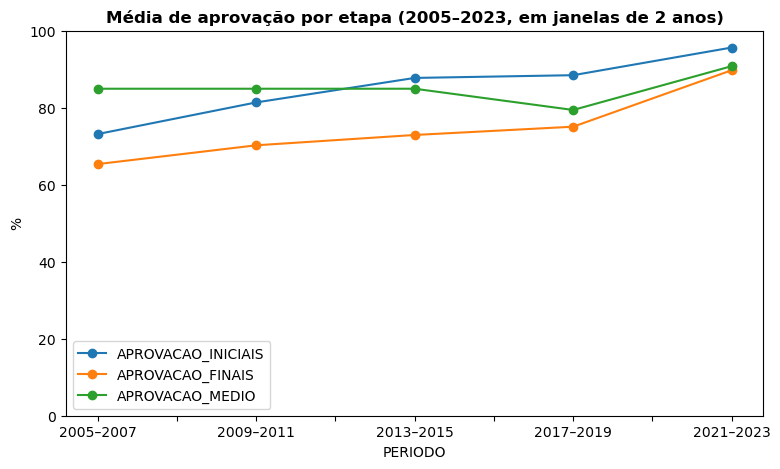

In [32]:
# Criar janelas de 3 anos
evolucao_filtrada["PERIODO"] = pd.cut(
    evolucao_filtrada["ANO"],
    bins=[2004,2007,2011,2015,2019,2023],  # intervalos
    labels=["2005–2007","2009–2011","2013–2015","2017–2019","2021–2023"]
)

# Calcular médias por município e período
grouped = (evolucao_filtrada
           .groupby(["MUNICIPIO_NOME","PERIODO"])
           [["APROVACAO_INICIAIS","APROVACAO_FINAIS","APROVACAO_MEDIO"]]
           .mean()
           .reset_index())

# Exemplo: média geral por período (todos municípios juntos)
media_geral = (grouped.groupby("PERIODO")[["APROVACAO_INICIAIS",
                                           "APROVACAO_FINAIS",
                                           "APROVACAO_MEDIO"]]
               .mean()*100)

ax = media_geral.plot(marker="o", figsize=(9,5))
ax.set_title("Média de aprovação por etapa (2005–2023, em janelas de 2 anos)", fontsize=12, weight="bold")
ax.set_ylabel("%")
ax.set_ylim(0,100)
plt.show()


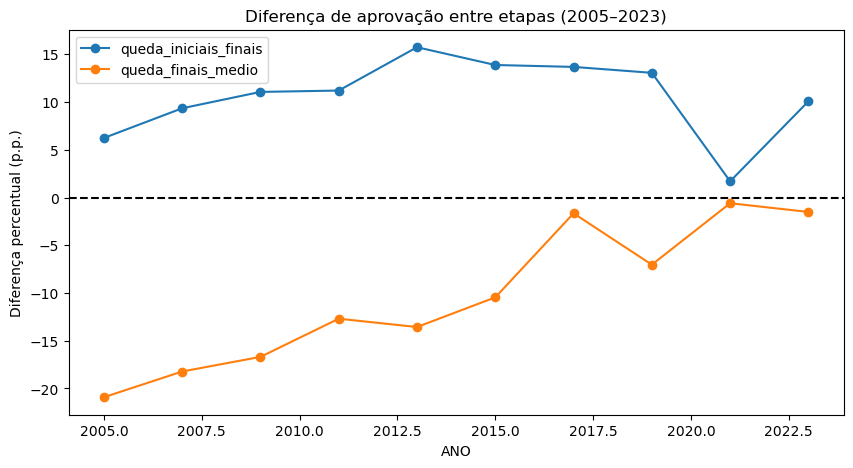

In [33]:
gap = evolucao_filtrada.groupby("ANO")[["APROVACAO_INICIAIS","APROVACAO_FINAIS","APROVACAO_MEDIO"]].mean()*100
gap["queda_iniciais_finais"] = gap["APROVACAO_INICIAIS"] - gap["APROVACAO_FINAIS"]
gap["queda_finais_medio"] = gap["APROVACAO_FINAIS"] - gap["APROVACAO_MEDIO"]

gap[["queda_iniciais_finais","queda_finais_medio"]].plot(figsize=(10,5), marker="o")
plt.title("Diferença de aprovação entre etapas (2005–2023)")
plt.ylabel("Diferença percentual (p.p.)")
plt.axhline(0, color="black", linestyle="--")
plt.show()


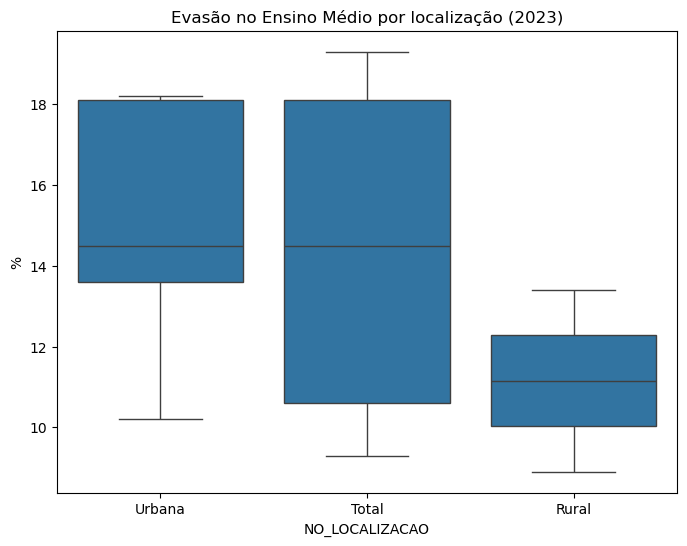

In [34]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.boxplot(data=urgentes, x="NO_LOCALIZACAO", y="Evasão -Médio")
plt.title("Evasão no Ensino Médio por localização (2023)")
plt.ylabel("%")
plt.show()


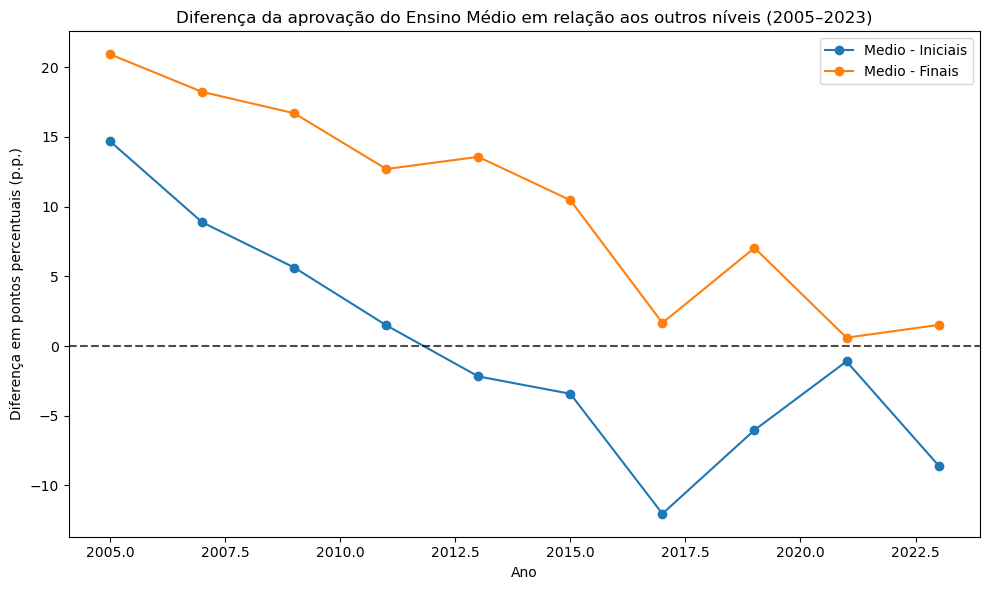

In [35]:
import matplotlib.pyplot as plt

# calcula a média de cada etapa por ano
medias = evolucao_filtrada.groupby("ANO")[["APROVACAO_INICIAIS",
                                           "APROVACAO_FINAIS",
                                           "APROVACAO_MEDIO"]].mean()

# diferença em pontos percentuais entre Médio e Iniciais/Finais
diff = pd.DataFrame({
    "Medio - Iniciais": (medias["APROVACAO_MEDIO"] - medias["APROVACAO_INICIAIS"]) * 100,
    "Medio - Finais":   (medias["APROVACAO_MEDIO"] - medias["APROVACAO_FINAIS"]) * 100
}, index=medias.index)

# plota
plt.figure(figsize=(10,6))
for col in diff.columns:
    plt.plot(diff.index, diff[col], marker="o", label=col)

plt.axhline(0, color="black", linestyle="--", alpha=0.7)
plt.title("Diferença da aprovação do Ensino Médio em relação aos outros níveis (2005–2023)")
plt.xlabel("Ano")
plt.ylabel("Diferença em pontos percentuais (p.p.)")
plt.legend()
plt.tight_layout()
plt.show()


Top 10 municipios mais urgentes


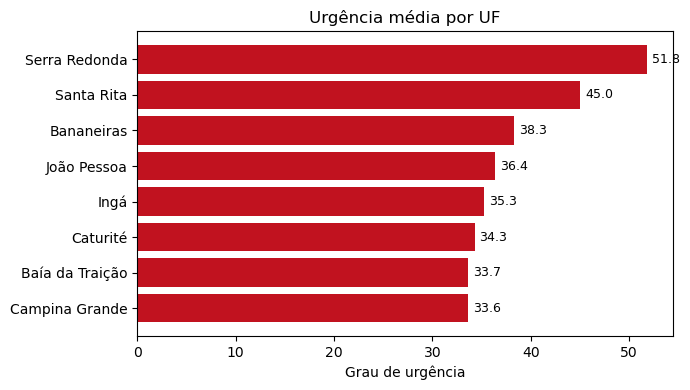

In [36]:
# use 'UF' ou 'UF_SIGLA' dependendo do nome que existir
uf_col = "NO_MUNICIPIO" if "UF_SIGLA" in urgentes.columns else "UF"
if uf_col in urgentes.columns:
    por_uf = (urgentes.groupby(uf_col, as_index=False)["Urgencia"].mean()
                      .sort_values("Urgencia", ascending=False))
    plt.figure(figsize=(7,4))
    bars = plt.barh(por_uf[uf_col], por_uf["Urgencia"], color="#c1121f")
    plt.gca().invert_yaxis()
    for b in bars:
        plt.text(b.get_width()+0.5, b.get_y()+b.get_height()/2, f"{b.get_width():.1f}",
                 va="center", fontsize=9)
    plt.xlabel("Grau de urgência"); plt.title("Urgência média por UF")
    plt.tight_layout(); plt.show()


3.2 Evolução histórica (Ensino Médio) dos TOP 5 urgentes

In [47]:
import pandas as pd
import numpy as np
import plotly.express as px
import re

# ================================
# Helpers
# ================================
def _slug(s: str) -> str:
    s = str(s).strip().lower()
    trans = str.maketrans({
        "ã":"a","â":"a","á":"a","à":"a",
        "é":"e","ê":"e","è":"e",
        "í":"i",
        "ó":"o","ô":"o","õ":"o",
        "ú":"u",
        "ç":"c"
    })
    s = s.translate(trans)
    s = re.sub(r"[^a-z0-9]+", "_", s)
    return s

def _minmax(s: pd.Series) -> pd.Series:
    s = s.astype(float)
    if s.max() == s.min():
        return pd.Series(0.5, index=s.index)
    return (s - s.min()) / (s.max() - s.min())

# ================================
# 1) Preparar URGENTES
#    - manter apenas Total/Total para evitar duplicatas
#    - padronizar nomes/colunas
# ================================
urg = urgentes.copy()

# Preferir Total/Total; se não houver, seguimos com o que tiver
if {"NO_LOCALIZACAO","NO_DEPENDENCIA"}.issubset(urg.columns):
    sel = (urg["NO_LOCALIZACAO"].astype(str).str.upper() == "TOTAL") & \
          (urg["NO_DEPENDENCIA"].astype(str).str.upper() == "TOTAL")
    if sel.any():
        urg = urg[sel].copy()

# renomear colunas-chave
col_nome_urg = "NO_MUNICIPIO" if "NO_MUNICIPIO" in urg.columns else "MUNICIPIO_NOME_ALP"
urg = urg.rename(columns={
    col_nome_urg: "MUNICIPIO_NOME",
    "Evasão - Fundamental": "EVASAO_FUNDAMENTAL",
    "Evasão - Médio": "EVASAO_MEDIO"
})

# keep só o necessário e reduzir por município (caso ainda tenha múltiplas linhas)
keep_urg = ["MUNICIPIO_NOME"]
for c in ["EVASAO_FUNDAMENTAL","EVASAO_MEDIO"]:
    if c in urg.columns: keep_urg.append(c)
urg = urg[keep_urg].copy()
urg["MUNICIPIO_NOME"] = urg["MUNICIPIO_NOME"].astype(str).str.strip()
urg = urg.groupby("MUNICIPIO_NOME", as_index=False).mean(numeric_only=True)

# ================================
# 2) Preparar DF_FILTRADO (aprovações por ano)
#    - converter 0–1 para % (0–100)
# ================================
evo = evolucao_filtrada.copy()
evo["MUNICIPIO_NOME"] = evo["MUNICIPIO_NOME"].astype(str).str.strip()

for c in ["APROVACAO_INICIAIS","APROVACAO_FINAIS"]:
    if c in evo.columns:
        # se já estiver em % (0-100), não muda; caso esteja 0–1, multiplicar por 100
        # heurística: se média <= 1.5, consideramos proporção
        mean_val = pd.to_numeric(evo[c], errors="coerce").mean()
        if pd.notna(mean_val) and mean_val <= 1.5:
            evo[c + "_%"] = 100 * pd.to_numeric(evo[c], errors="coerce")
        else:
            evo[c + "_%"] = pd.to_numeric(evo[c], errors="coerce")
    else:
        evo[c + "_%"] = np.nan

# ================================
# 3) Agregados "estáticos" por município
#    - use a MÉDIA do período (robusto) ou o ÚLTIMO ano (snapshot)
#    -> abaixo: média; comente a média e descomente o "last" se preferir
# ================================
# média do período
df_static = (
    evo.groupby(["MUNICIPIO_NOME"], as_index=False)[["APROVACAO_INICIAIS_%","APROVACAO_FINAIS_%"]]
       .mean(numeric_only=True)
)

# --- alternativa: último ano disponível por município ---
# idx = evo.groupby("MUNICIPIO_NOME")["ANO"].idxmax()
# df_static = evo.loc[idx, ["MUNICIPIO_NOME","APROVACAO_INICIAIS_%","APROVACAO_FINAIS_%"]].reset_index(drop=True)

# merge evasão
df_static = df_static.merge(urg, on="MUNICIPIO_NOME", how="left")

# métricas derivadas
df_static["GAP_APROV_%"] = df_static["APROVACAO_INICIAIS_%"] - df_static["APROVACAO_FINAIS_%"]

aprov_finais_norm = 1 - _minmax(df_static["APROVACAO_FINAIS_%"].fillna(df_static["APROVACAO_FINAIS_%"].median()))
evasao_norm       = _minmax(df_static["EVASAO_FUNDAMENTAL"].fillna(df_static["EVASAO_FUNDAMENTAL"].median()))
gap_norm          = _minmax(df_static["GAP_APROV_%"].fillna(0))

df_static["SCORE_RISCO"] = 0.5*aprov_finais_norm + 0.4*evasao_norm + 0.1*gap_norm

# ================================
# 4) Gráficos
# ================================
def graf_tendencia_geral(evo=evo):
    t = evo.dropna(subset=["ANO","APROVACAO_INICIAIS_%","APROVACAO_FINAIS_%"]).copy()
    m = t.groupby("ANO", as_index=False)[["APROVACAO_INICIAIS_%","APROVACAO_FINAIS_%"]].mean()
    melted = m.melt(id_vars="ANO", var_name="Etapa", value_name="Aprovação (%)")
    fig = px.line(melted, x="ANO", y="Aprovação (%)", color="Etapa", markers=True,
                  title="Tendência Geral — Aprovação Iniciais vs Finais (média do recorte)")
    fig.update_layout(yaxis_tickformat=".1f")
    return fig

def graf_gap_aprov(base=df_static, top_n=25):
    t = base.dropna(subset=["GAP_APROV_%"]).copy()
    t = t.sort_values("GAP_APROV_%", ascending=False).head(top_n)
    fig = px.bar(t, x="GAP_APROV_%", y="MUNICIPIO_NOME", orientation="h",
                 title=f"Gargalo (GAP) de Aprovação — Iniciais − Finais (Top {top_n})",
                 labels={"MUNICIPIO_NOME":"Município","GAP_APROV_%":"GAP (p.p.)"})
    fig.update_yaxes(categoryorder="total ascending")
    return fig

def graf_quadrantes(base=df_static):
    t = base.dropna(subset=["APROVACAO_FINAIS_%","EVASAO_FUNDAMENTAL"]).copy()
    cut_aprov = t["APROVACAO_FINAIS_%"].median()
    cut_evas  = t["EVASAO_FUNDAMENTAL"].median()

    conds = [
        (t["APROVACAO_FINAIS_%"] < cut_aprov) & (t["EVASAO_FUNDAMENTAL"] > cut_evas),
        (t["APROVACAO_FINAIS_%"] >= cut_aprov) & (t["EVASAO_FUNDAMENTAL"] > cut_evas),
        (t["APROVACAO_FINAIS_%"] < cut_aprov) & (t["EVASAO_FUNDAMENTAL"] <= cut_evas),
        (t["APROVACAO_FINAIS_%"] >= cut_aprov) & (t["EVASAO_FUNDAMENTAL"] <= cut_evas),
    ]
    labels = ["Crítico (aprov baixa, evas alta)","Atenção (aprov alta, evas alta)",
              "Apoio pedagógico (aprov baixa, evas baixa)","OK (aprov alta, evas baixa)"]
    t["Quadrante"] = np.select(conds, labels)

    fig = px.scatter(
        t, x="APROVACAO_FINAIS_%", y="EVASAO_FUNDAMENTAL", color="Quadrante",
        hover_data=["MUNICIPIO_NOME","APROVACAO_INICIAIS_%","GAP_APROV_%","SCORE_RISCO"],
        title="Quadrantes — Aprovação (Anos Finais) × Evasão (Fundamental)",
        labels={"APROVACAO_FINAIS_%":"Aprovação Finais (%)","EVASAO_FUNDAMENTAL":"Evasão Fundamental (%)"}
    )
    fig.add_vline(x=cut_aprov); fig.add_hline(y=cut_evas)
    return fig

def graf_ranking_risco(base=df_static, top_n=20):
    t = base.dropna(subset=["SCORE_RISCO"]).copy()
    t = t.sort_values("SCORE_RISCO", ascending=False).head(top_n)
    fig = px.bar(
        t, x="SCORE_RISCO", y="MUNICIPIO_NOME", orientation="h",
        hover_data=["APROVACAO_INICIAIS_%","APROVACAO_FINAIS_%","EVASAO_FUNDAMENTAL","GAP_APROV_%"],
        title=f"Top {top_n} — Ranking de Risco (baixa aprov finais + alta evasão + gap)",
        labels={"MUNICIPIO_NOME":"Município","SCORE_RISCO":"Score de Risco (0–1)"}
    )
    fig.update_yaxes(categoryorder="total ascending")
    return fig

def graf_tendencia_municipio(municipio_nome, evo=evo):
    t = evo[evo["MUNICIPIO_NOME"].astype(str).str.strip() == str(municipio_nome).strip()].copy()
    t = t.dropna(subset=["ANO","APROVACAO_INICIAIS_%","APROVACAO_FINAIS_%"])
    if t.empty:
        raise ValueError(f"Município '{municipio_nome}' não encontrado em df_filtrado.")
    m = t.groupby("ANO", as_index=False)[["APROVACAO_INICIAIS_%","APROVACAO_FINAIS_%"]].mean()
    melted = m.melt(id_vars="ANO", var_name="Etapa", value_name="Aprovação (%)")
    fig = px.line(melted, x="ANO", y="Aprovação (%)", color="Etapa", markers=True,
                  title=f"{municipio_nome} — Evolução de Aprovação (Iniciais vs Finais)")
    fig.update_layout(yaxis_tickformat=".1f")
    return fig

# ================================
# Exemplos de uso (Jupyter)
# ================================
graf_tendencia_geral().show()
graf_gap_aprov().show()
graf_quadrantes().show()
graf_ranking_risco().show()



In [50]:
import pandas as pd
import numpy as np
import plotly.express as px
import re

# --- helpers (use os mesmos do seu script) ---
def _slug(s: str) -> str:
    s = str(s).strip().lower()
    trans = str.maketrans({"ã":"a","â":"a","á":"a","à":"a",
                           "é":"e","ê":"e","è":"e",
                           "í":"i",
                           "ó":"o","ô":"o","õ":"o",
                           "ú":"u","ç":"c"})
    s = s.translate(trans)
    s = re.sub(r"[^a-z0-9]+", "_", s)
    return s

def _minmax(s: pd.Series) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce").astype(float)
    if s.dropna().empty or s.max() == s.min():
        return pd.Series(0.5, index=s.index)
    return (s - s.min()) / (s.max() - s.min())


# ======================================================
# 1) Padronizar e criar CHAVE de merge por slug
# ======================================================
# --- URGENTES ---
urg = urgentes.copy()
# preferir Total/Total quando existir
if {"NO_LOCALIZACAO","NO_DEPENDENCIA"}.issubset(urg.columns):
    mask_total = (urg["NO_LOCALIZACAO"].astype(str).str.upper()=="TOTAL") & \
                 (urg["NO_DEPENDENCIA"].astype(str).str.upper()=="TOTAL")
    if mask_total.any():
        urg = urg[mask_total].copy()

col_nome_urg = "NO_MUNICIPIO" if "NO_MUNICIPIO" in urg.columns else "MUNICIPIO_NOME_ALP"
urg = urg.rename(columns={
    col_nome_urg: "MUNICIPIO_NOME",
    "Evasão - Fundamental": "EVASAO_FUNDAMENTAL",
    "Evasão - Médio": "EVASAO_MEDIO"
})
urg["MUNICIPIO_NOME"] = urg["MUNICIPIO_NOME"].astype(str).str.strip()
urg["MUN_KEY"] = urg["MUNICIPIO_NOME"].map(_slug)

# reduzir por município
keep = ["MUN_KEY","MUNICIPIO_NOME"]
for c in ["EVASAO_FUNDAMENTAL","EVASAO_MEDIO"]:
    if c in urg.columns: keep.append(c)
urg = urg[keep].groupby(["MUN_KEY","MUNICIPIO_NOME"], as_index=False).mean(numeric_only=True)

# --- DF_FILTRADO ---
evo = evolucao_filtrada.copy()
evo["MUNICIPIO_NOME"] = evo["MUNICIPIO_NOME"].astype(str).str.strip()
evo["MUN_KEY"] = evo["MUNICIPIO_NOME"].map(_slug)

# garantir colunas em %
for c in ["APROVACAO_INICIAIS","APROVACAO_FINAIS"]:
    if c in evo.columns:
        v = pd.to_numeric(evo[c], errors="coerce")
        if v.mean(skipna=True) <= 1.5:  # estava em proporção
            evo[c + "_%"] = 100*v
        else:
            evo[c + "_%"] = v
    else:
        evo[c + "_%"] = np.nan

# ======================================================
# 2) DF estático por município (média do período ou último ano)
#    -> escolha UM modo: "media" (default) ou "ultimo"
# ======================================================
def build_df_static(evo: pd.DataFrame, urg: pd.DataFrame, modo="media") -> pd.DataFrame:
    if modo == "ultimo":
        idx = evo.groupby("MUN_KEY")["ANO"].idxmax()
        base = evo.loc[idx, ["MUN_KEY","MUNICIPIO_NOME","APROVACAO_INICIAIS_%","APROVACAO_FINAIS_%"]].copy()
    else:  # média
        base = (
            evo.groupby(["MUN_KEY","MUNICIPIO_NOME"], as_index=False)[["APROVACAO_INICIAIS_%","APROVACAO_FINAIS_%"]]
               .mean(numeric_only=True)
        )

    df_static = base.merge(urg[["MUN_KEY","EVASAO_FUNDAMENTAL"]], on="MUN_KEY", how="left")
    df_static["GAP_APROV_%"] = df_static["APROVACAO_INICIAIS_%"] - df_static["APROVACAO_FINAIS_%"]

    aprov_finais_norm = 1 - _minmax(df_static["APROVACAO_FINAIS_%"].fillna(df_static["APROVACAO_FINAIS_%"].median()))
    evasao_norm       = _minmax(df_static["EVASAO_FUNDAMENTAL"].fillna(df_static["EVASAO_FUNDAMENTAL"].median()))
    gap_norm          = _minmax(df_static["GAP_APROV_%"].fillna(0))
    df_static["SCORE_RISCO"] = 0.5*aprov_finais_norm + 0.4*evasao_norm + 0.1*gap_norm
    return df_static

df_static = build_df_static(evo, urg, modo="media")

# --- SANITY CHECK (opcional, comente se não quiser prints) ---
print("Municipios em df_filtrado:", evo["MUN_KEY"].nunique())
print("Municipios em urgentes:", urg["MUN_KEY"].nunique())
print("Após merge (df_static)   :", df_static.shape, "NaN evasão:", df_static["EVASAO_FUNDAMENTAL"].isna().sum())


# ======================================================
# 3) Gráfico de Quadrantes robusto (com aviso)
# ======================================================
def graf_quadrantes(base=df_static):
    cols_needed = ["APROVACAO_FINAIS_%","EVASAO_FUNDAMENTAL"]
    t = base.dropna(subset=[c for c in cols_needed if c in base.columns]).copy()

    if t.empty:
        raise ValueError(
            "Sem dados para plotar: após o merge, 'APROVACAO_FINAIS_%' ou 'EVASAO_FUNDAMENTAL' ficou vazio.\n"
            "Dica: verifique se os municípios casaram (use a chave MUN_KEY) e se existem valores não-nulos."
        )

    cut_aprov = t["APROVACAO_FINAIS_%"].median()
    cut_evas  = t["EVASAO_FUNDAMENTAL"].median()

    conds = [
        (t["APROVACAO_FINAIS_%"] < cut_aprov) & (t["EVASAO_FUNDAMENTAL"] > cut_evas),
        (t["APROVACAO_FINAIS_%"] >= cut_aprov) & (t["EVASAO_FUNDAMENTAL"] > cut_evas),
        (t["APROVACAO_FINAIS_%"] < cut_aprov) & (t["EVASAO_FUNDAMENTAL"] <= cut_evas),
        (t["APROVACAO_FINAIS_%"] >= cut_aprov) & (t["EVASAO_FUNDAMENTAL"] <= cut_evas),
    ]
    labels = ["Crítico (aprov baixa, evas alta)",
              "Atenção (aprov alta, evas alta)",
              "Apoio pedagógico (aprov baixa, evas baixa)",
              "OK (aprov alta, evas baixa)"]
    t["Quadrante"] = np.select(conds, labels)

    fig = px.scatter(
        t, x="APROVACAO_FINAIS_%", y="EVASAO_FUNDAMENTAL", color="Quadrante",
        hover_data=["MUNICIPIO_NOME","APROVACAO_INICIAIS_%","GAP_APROV_%","SCORE_RISCO"],
        title="Quadrantes — Aprovação (Anos Finais) × Evasão (Fundamental)",
        labels={"APROVACAO_FINAIS_%":"Aprovação Finais (%)","EVASAO_FUNDAMENTAL":"Evasão Fundamental (%)"}
    )
    fig.add_vline(x=cut_aprov); fig.add_hline(y=cut_evas)
    return fig
graf_quadrantes().show()

Municipios em df_filtrado: 8
Municipios em urgentes: 5
Após merge (df_static)   : (8, 7) NaN evasão: 3


In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

def graf_quadrantes(base=df_static, usar_tamanho_por_risco=True):
    t = base.dropna(subset=["APROVACAO_FINAIS_%","EVASAO_FUNDAMENTAL"]).copy()
    if t.empty:
        raise ValueError("Sem dados para plotar quadrantes.")

    # Cortes (medianas)
    cut_x = t["APROVACAO_FINAIS_%"].median()
    cut_y = t["EVASAO_FUNDAMENTAL"].median()

    # Rótulo de quadrante
    conds = [
        (t["APROVACAO_FINAIS_%"] < cut_x) & (t["EVASAO_FUNDAMENTAL"] > cut_y),
        (t["APROVACAO_FINAIS_%"] >= cut_x) & (t["EVASAO_FUNDAMENTAL"] > cut_y),
        (t["APROVACAO_FINAIS_%"] < cut_x) & (t["EVASAO_FUNDAMENTAL"] <= cut_y),
        (t["APROVACAO_FINAIS_%"] >= cut_x) & (t["EVASAO_FUNDAMENTAL"] <= cut_y),
    ]
    labels = ["Crítico (aprov baixa, evas alta)",
              "Atenção (aprov alta, evas alta)",
              "Apoio pedagógico (aprov baixa, evasão baixa)",
              "OK (aprov alta, evasão baixa)"]
    t["Quadrante"] = np.select(conds, labels)

    # Abrevia nome para rótulo curto no ponto
    t["LABEL"] = t["MUNICIPIO_NOME"].str.title().str.slice(0, 18)

    # Range com folga
    pad_x = max(1.0, (t["APROVACAO_FINAIS_%"].max() - t["APROVACAO_FINAIS_%"].min())*0.06)
    pad_y = max(0.5, (t["EVASAO_FUNDAMENTAL"].max() - t["EVASAO_FUNDAMENTAL"].min())*0.08)
    xr = [t["APROVACAO_FINAIS_%"].min()-pad_x, t["APROVACAO_FINAIS_%"].max()+pad_x]
    yr = [t["EVASAO_FUNDAMENTAL"].min()-pad_y, t["EVASAO_FUNDAMENTAL"].max()+pad_y]

    size_arg = "SCORE_RISCO" if usar_tamanho_por_risco and "SCORE_RISCO" in t.columns else None

    fig = px.scatter(
        t, x="APROVACAO_FINAIS_%", y="EVASAO_FUNDAMENTAL",
        color="Quadrante", size=size_arg, size_max=26,
        hover_data=["MUNICIPIO_NOME","APROVACAO_INICIAIS_%","GAP_APROV_%","SCORE_RISCO"],
        text="LABEL",
        title="Quadrantes — Aprovação (Anos Finais) × Evasão (Fundamental)",
        labels={"APROVACAO_FINAIS_%":"Aprovação Finais (%)","EVASAO_FUNDAMENTAL":"Evasão Fundamental (%)"},
    )

    # Pontos maiores, rótulos acima
    fig.update_traces(marker=dict(line=dict(width=1, color="white"), opacity=0.9))
    fig.update_traces(textposition="top center", textfont=dict(size=11))

    # Sombras dos quadrantes
    fig.add_shape(type="rect", x0=xr[0], x1=cut_x, y0=cut_y, y1=yr[1], fillcolor="red", opacity=0.06, line_width=0)
    fig.add_shape(type="rect", x0=cut_x, x1=xr[1], y0=cut_y, y1=yr[1], fillcolor="orange", opacity=0.06, line_width=0)
    fig.add_shape(type="rect", x0=xr[0], x1=cut_x, y0=yr[0], y1=cut_y, fillcolor="gray", opacity=0.06, line_width=0)
    fig.add_shape(type="rect", x0=cut_x, x1=xr[1], y0=yr[0], y1=cut_y, fillcolor="green", opacity=0.06, line_width=0)

    # Linhas de corte mais visíveis
    fig.add_vline(x=cut_x, line_width=3, line_dash="dash")
    fig.add_hline(y=cut_y, line_width=3, line_dash="dash")

    # Anotações dos quadrantes
    fig.add_annotation(x=xr[0]+(cut_x-xr[0])*0.08, y=yr[1]-(yr[1]-cut_y)*0.60,
                       text="Crítico", showarrow=False, font=dict(size=12, color="red"))
    fig.add_annotation(x=cut_x+(xr[1]-cut_x)*0.85, y=yr[1]-(yr[1]-cut_y)*0.15,
                       text="Atenção", showarrow=False, font=dict(size=12, color="orange"))
    fig.add_annotation(x=xr[0]+(cut_x-xr[0])*0.15, y=cut_y-(cut_y-yr[0])*0.15,
                       text="Apoio pedagógico", showarrow=False, font=dict(size=12, color="gray"))
    fig.add_annotation(x=cut_x+(xr[1]-cut_x)*0.85, y=cut_y-(cut_y-yr[0])*0.15,
                       text="OK", showarrow=False, font=dict(size=12, color="green"))


    # Layout
    fig.update_layout(
        xaxis=dict(range=xr, tickformat=".1f"),
        yaxis=dict(range=yr, tickformat=".1f"),
        legend_title_text="Quadrante",
        margin=dict(l=10, r=10, t=60, b=10),
    )
    return fig
graf_quadrantes().show()

In [76]:
def graf_ranking_risco(base=df_static, top_n=20):
    df = base.copy()

    # --- garante SCORE_RISCO calculado ---
    if "SCORE_RISCO" not in df.columns or df["SCORE_RISCO"].isna().all():
        aprov_finais_norm = 1 - _minmax(df["APROVACAO_FINAIS_%"].fillna(df["APROVACAO_FINAIS_%"].median()))
        evasao_norm       = _minmax(df["EVASAO_FUNDAMENTAL"].fillna(df["EVASAO_FUNDAMENTAL"].median()))
        gap_norm          = _minmax(df["GAP_APROV_%"].fillna(0))
        df["SCORE_RISCO"] = 0.5*aprov_finais_norm + 0.4*evasao_norm + 0.1*gap_norm

    # --- remove linhas totalmente nulas ---
    df = df.dropna(subset=["SCORE_RISCO","MUNICIPIO_NOME"])

    if df.empty:
        raise ValueError("Nenhum município com SCORE_RISCO válido. Confira se o merge trouxe valores para evasão e aprovação.")

    df = df.sort_values("SCORE_RISCO", ascending=False).head(top_n)

    fig = px.bar(
        df, x="SCORE_RISCO", y="MUNICIPIO_NOME", orientation="h",
        hover_data=["APROVACAO_INICIAIS_%","APROVACAO_FINAIS_%","EVASAO_FUNDAMENTAL","GAP_APROV_%"],
        title=f"Top {top_n} — Ranking de Risco (baixa aprov finais + alta evasão + gap)",
        labels={"MUNICIPIO_NOME":"Município","SCORE_RISCO":"Score de Risco (0–1)"}
    )
    fig.update_yaxes(categoryorder="total ascending")
    return fig
graf_ranking_risco().show() 